# Imports and few functions/variables

In [47]:


import numpy as np
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('..'), os.path.pardir)))
from ForecastingModel.Forecaster import Forecaster
from ForecastingModel.models.LinearDropout import LinearDropout
from ForecastingModel.models.MLP import MLP
from ForecastingModel.models.LSTMEncodedStatic import LSTMEncodedStatic
from ForecastingModel.models.LSTMVanilla import LSTMVanilla
from ForecastingModel.ScoreFunctions import * 
from ForecastingModel.DownloadRuns import get_best_run_info_from_last_sweep, get_best_run_info_from_each_sweep, get_best_run_info_from_ith_sweep, get_results_prob, get_results_pt_model_per_dma, get_results_pt_dma_together
from ForecastingModel.ScoreFunctions import compute_MAE_2d
import plotly.graph_objects as go
import pandas as pd
import plotly.offline as pyo
import re
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import plotly.graph_objs as go
import pandas as pd
import webbrowser


In [2]:
# get reloader to reload the functions imported from ForecastingModel.DownloadRuns 
# from importlib import reload
# import ForecastingModel.DownloadRuns
# reload(ForecastingModel.DownloadRuns)

DMAs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [125]:
def show_lowest_bold(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

def show_closest_95_bold(s):
    is_min = np.abs(s-0.95) == np.abs(s-0.95).min()
    return ['font-weight: bold' if v else '' for v in is_min]

def show_largest_bold(s):
    is_max = s ==s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

def show_closest_00_bold(s):
    is_min = np.abs(s) == np.abs(s).min()
    return ['font-weight: bold' if v else '' for v in is_min]

def show_closest_00_green(s):
    is_min = np.abs(s) == np.abs(s).min()
    return ['background-color: #d9ecd9; font-weight: bold' if v else '' for v in is_min]

def show_farthest_00_red(s):
    is_min = np.abs(s) == np.abs(s).max()
    return ['background-color: #ffd3d3; font-weight: bold' if v else '' for v in is_min]

def show_lowest_bold(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

def show_closest_95_bold(s):
    is_min = np.abs(s-0.95) == np.abs(s-0.95).min()
    return ['font-weight: bold' if v else '' for v in is_min]

def show_largest_bold(s):
    is_max = s ==s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

def show_largest_green(s):
    is_max = s ==s.max()
    return ['background-color: #d9ecd9; font-weight: bold' if v else '' for v in is_max]

def show_closest_00_bold(s):
    is_min = np.abs(s) == np.abs(s).min()
    return ['font-weight: bold' if v else '' for v in is_min]

def show_closest_95_green_else_red(s):
    is_min = np.abs(s-0.95) == np.abs(s-0.95).min()
    return ['background-color: #d9ecd9; font-weight: bold' if v else 'background-color: #ffd3d3; font-weight: bold' for v in is_min]

def show_closest_95_green(s):
    is_min = np.abs(s-0.95) == np.abs(s-0.95).min()
    return ['background-color: #d9ecd9; font-weight: bold' if v else '' for v in is_min]

def show_lowest_green(s):
    is_min = s == s.min()
    return ['background-color: #d9ecd9; font-weight: bold' if v else '' for v in is_min]

def show_farthest_95_red(s):
    # show the farthest from 95% in red
    is_min = np.abs(s-0.95) == np.abs(s-0.95).max()
    return ['background-color: #ffd3d3; font-weight: bold' if v else '' for v in is_min]
    
def color_min_max_subset(series):
    min_value = series.min()
    max_value = series.max()
    # Define color for min and max
    colors = []
    for value in series:
        if abs(value - min_value) < 0.005:
            colors.append('background-color: #d9ecd9; font-weight: bold')
        elif abs(value - max_value) < 0.005:
            colors.append('background-color: #ffd3d3; font-weight: bold')
        else:
            colors.append('')
    return colors

def format_styled_latex_table_with_booktabs(styled_df, caption):
    """
    Formats a styled DataFrame into a LaTeX table with booktabs, required formatting, and correct color replacement.

    Parameters:
    - styled_df (pd.io.formats.style.Styler): A styled DataFrame already containing formatting.
    - caption (str): The caption of the table. The label will be set to `table: <caption>`.

    Returns:
    - str: The fully formatted LaTeX table string.
    """
    label = f"table: {caption}"  # Automatically set the label based on the caption

    # Generate the LaTeX content of the styled DataFrame
    latex_content = styled_df.format("{:.2f}",na_rep='-').to_latex(hrules=True)

    # Replace background colors defined as hex with corresponding LaTeX color commands
    latex_content = re.sub(r'\\background-color#d9ecd9\s*', r'\\cellcolor{lightgreen} ', latex_content)
    latex_content = re.sub(r'\\background-color#ffd3d3\s*', r'\\cellcolor{lightred} ', latex_content)
    

    # Replace bold formatting with \textbf{...}
    # This regex finds \font-weightbold followed by content and wraps the content in braces
    latex_content = re.sub(r'\\font-weightbold\s*([^&%$#_{}\s]+)', r'\\textbf{\1}', latex_content)

    # For cases where the bold text may contain spaces or special characters, we can use a more comprehensive pattern
    # Modify the regex to capture until the next LaTeX separator (& or \\)
    latex_content = re.sub(
        r'\\font-weightbold\s*(.+?)(&|\\\\)', 
        lambda m: '\\textbf{' + m.group(1).strip() + '}' + m.group(2), 
        latex_content, 
        flags=re.DOTALL
    )

    # Wrap the LaTeX content with the required formatting
    formatted_table = (
        f"\\begin{{table}}[H]\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        f"\\centering\n"
        f"\\resizebox{{\\textwidth}}{{!}}{{%\n"
        f"{latex_content}\n"
        f"}}\n"
        f"\\end{{table}}"
    )

    return formatted_table





In [4]:
# make all column names that are longer than 42 characters shorter BY adding a newline after the middle word
new_column_names = ['A: Hospital district', 'B: Residential district in the countryside', 'C: Residential District in the countryside', 'D: Suburban residential/commercial district', 'E: Residential/commercial district close to the city centre', 'F: Suburban district including sport facilities and office buildings', 'G: Residential district close to the city centre', 'H: City centre district', 'I: Commerical/industrial district close to the port', 'J: Commerical/industrial district close to the port']
# add DMA in front of the column names
new_column_names = ['DMA ' + i for i in new_column_names]
new_column_names_with_newlines = []

for name in new_column_names:
    if len(name) > 30:
        word_list = name.split(' ')
        middle = int(len(word_list) / 1.7)
        word_list.insert(middle, '\n')
        new_name = ' '.join(word_list)
        new_column_names_with_newlines.append(new_name)
    else:
        new_column_names_with_newlines.append(name)
new_column_names_with_newlines

['DMA A: Hospital district',
 'DMA B: Residential district \n in the countryside',
 'DMA C: Residential District \n in the countryside',
 'DMA D: \n Suburban residential/commercial district',
 'DMA E: Residential/commercial district close \n to the city centre',
 'DMA F: Suburban district including \n sport facilities and office buildings',
 'DMA G: Residential district close \n to the city centre',
 'DMA H: City centre district',
 'DMA I: Commerical/industrial district \n close to the port',
 'DMA J: Commerical/industrial district \n close to the port']

In [5]:
new_column_names_with_newlines

['DMA A: Hospital district',
 'DMA B: Residential district \n in the countryside',
 'DMA C: Residential District \n in the countryside',
 'DMA D: \n Suburban residential/commercial district',
 'DMA E: Residential/commercial district close \n to the city centre',
 'DMA F: Suburban district including \n sport facilities and office buildings',
 'DMA G: Residential district close \n to the city centre',
 'DMA H: City centre district',
 'DMA I: Commerical/industrial district \n close to the port',
 'DMA J: Commerical/industrial district \n close to the port']

# Probabilistic results probabilistic models

In [6]:
# # from now we analyze the probabilistic forecasts
project_list_QR = [
    '00_MLP_QR_rpb_FINAL99'
]

project_list_MDN = [
    '00_MLP_MDN_FINAL99',
]


    
# uncommetn download the best model from the hyperparameter optimization

# for project in project_list_QR:
#     get_best_run_info_from_last_sweep(project, results_folder, download=True)
# for project in project_list_MDN:
#     get_best_run_info_from_last_sweep(project, results_folder, download=True)



In [7]:
result_dict_qr_2 = get_results_prob(project_list_QR[0], MLP)
result_dict_mdn_2 = get_results_prob(project_list_MDN[0], MLP)


In [8]:
result_dict_qr_2['config']

{'batch_size': 256,
 'clip_grad': None,
 'crit_nr_to_optimize': 1,
 'crit_nr_to_save': 1,
 'criterion': 'QuantileLoss',
 'data_keys': ['historic'],
 'delta_1': 0,
 'dropout_rate': 0.15,
 'early_stopping': False,
 'echo_iter': 10,
 'forecast_sequence_length': 24,
 'hidden_layers': 1,
 'hidden_size': 256,
 'historic_sequence_length': 168,
 'l1_penalty': 0,
 'learning_rate': 0.0025316528800352982,
 'num_epochs': 250,
 'patience_1': 0,
 'patience_2': 0,
 'probabilistic_method': 'quantile_regression',
 'quantiles': [0.025, 0.5, 0.975],
 'wandb_logging': False,
 'weight_decay': 0,
 'train_time': 2.8549732605616254,
 'nr_params': 127560}

In [9]:
result_dict_mdn_2['config']

{'batch_size': 256,
 'clip_grad': None,
 'crit_nr_to_optimize': 1,
 'crit_nr_to_save': 1,
 'criterion': 'GMMLoss',
 'data_keys': ['historic'],
 'delta_1': 0,
 'dropout_rate': 0.2,
 'early_stopping': False,
 'echo_iter': 10,
 'forecast_sequence_length': 24,
 'hidden_layers': 1,
 'hidden_size': 256,
 'historic_sequence_length': 168,
 'l1_penalty': 0,
 'learning_rate': 0.000554226893449932,
 'mdn_variance_regularization': 0,
 'mdn_weights_regularization': 0,
 'num_epochs': 250,
 'num_mdn_samples': 1000,
 'number_of_gaussians': 4,
 'patience_1': 0,
 'patience_2': 0,
 'probabilistic_method': 'mixture_density_network',
 'quantiles': [0.025, 0.5, 0.975],
 'wandb_logging': False,
 'weight_decay': 0,
 'train_time': 3.4065550327301026,
 'nr_params': 183072}

In [10]:
# get the metrics from the learned models
df_metrics_mdn_2_test = result_dict_mdn_2['test']['1d_metrics_interval']
df_metrics_qr_2_test = result_dict_qr_2['test']['1d_metrics_interval']
df_metrics_mdn_2_val = result_dict_mdn_2['val']['1d_metrics_interval']
df_metrics_qr_2_val = result_dict_qr_2['val']['1d_metrics_interval']


In [11]:
# get the mcd results
mcd_prob_test = torch.load('./results/TESTING_MLP_MCD_VAL2/results_probabilistic.pt')


In [12]:
index_proba = ['Cov. Gap', 'PICP', 'PINAW', 'Robust Pinaw', 'Width']
DMAs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [13]:
dropout_rates = [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['dropout_rate'] for dma in DMAs]
dropout_rates

[0.528125,
 0.2890625,
 0.359375,
 0.471875,
 0.10625000000000001,
 0.5843750000000001,
 0.2328125,
 0.1765625,
 0.5,
 0.415625]

In [14]:
df_metrics_mcd_test = pd.DataFrame()
df_metrics_mcd_val = pd.DataFrame()
df_dropout_rate = pd.DataFrame()
dropout_rate = []
calibrated_dropout_rate = []
for dma in DMAs:
    # dma = dma[4:5]
    series_dma = pd.Series(mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['metrics'])
    series_dma_val = pd.Series(mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_val']['metrics'])
    series_dma.index = index_proba
    series_dma_val.index = index_proba
    df_metrics_mcd_test[f'{dma}'] = series_dma
    df_metrics_mcd_val[f'{dma}'] = series_dma_val
    dropout_rate.append(mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['dropout_rate'])
    calibrated_dropout_rate.append(mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['fitted_dropout_rate'])
df_dropout_rate['Calibrated Dropout Rate'] = dropout_rate
df_dropout_rate['Dropout Rate Trained With'] = calibrated_dropout_rate
df_dropout_rate.index = DMAs

In [15]:
# get naive mdel

dict_results_naive = {}
name = '24h_out_all_no_weather'
scalers = torch.load('../data/processed/scaler_all.pt')
from ForecastingModel.ProbabilisticLosses import QuantileLoss

# compute quantile losses of the naive model
QL = QuantileLoss(
    quantiles=[0.025, 0.5, 0.975],
    device='cpu'
)
quantile_losses_naive_model_val_set = []

# iterate over the DMAs
for i, dma in enumerate(DMAs):
    y_test = torch.load(f'../data/sequences/{name}/test_y_{name}_{dma}.pt')

    scale1 = scalers.scale_[i]
    scale2 = scalers.mean_[i]
    y_test = y_test*scale1+scale2

    # load the naive model
    test_naive_up = torch.load(f'../data/sequences/{name}/test_naive_up_final_{name}_{dma}.pt')*scale1+scale2
    test_naive_low = torch.load(f'../data/sequences/{name}/test_naive_low_final_{name}_{dma}.pt')*scale1+scale2
    test_naive = torch.load(f'../data/sequences/{name}/test_naive_final_{name}_{dma}.pt')*scale1+scale2
    test_naive_prob = torch.stack([test_naive_low, test_naive, test_naive_up], dim=-1)
    
    # compute metrics picp etc
    picp_test_1d = compute_picp_1d(y_test,test_naive_prob)
    pinaw_test_1d = compute_pinaw_1d(y_test, test_naive_prob)
    cov_gap_test_1d = compute_cov_gap_1d(y_test, test_naive_prob)
    robust_pinaw_test_1d = compute_robust_pinaw_1d(y_test, test_naive_prob)
    width_test_1d = compute_width_1d(test_naive_prob)

    # compute 2d metrics
    picp_test_2d = compute_picp_2d(y_test,test_naive_prob)
    pinaw_test_2d = compute_pinaw_2d(y_test, test_naive_prob)
    cov_gap_test_2d = compute_cov_gap_2d(y_test, test_naive_prob)
    robust_pinaw_test_2d = compute_robust_pinaw_2d(y_test, test_naive_prob)
    width_test_2d = compute_width_2d(test_naive_prob)
    
    # repeat but for val set
    y_val = torch.load(f'../data/sequences/{name}/val_y_{name}_{dma}.pt')
    y_val = y_val*scale1+scale2
    val_naive_up = torch.load(f'../data/sequences/{name}/val_naive_up_final_{name}_{dma}.pt')*scale1+scale2
    val_naive_low = torch.load(f'../data/sequences/{name}/val_naive_low_final_{name}_{dma}.pt')*scale1+scale2
    val_naive = torch.load(f'../data/sequences/{name}/val_naive_final_{name}_{dma}.pt')*scale1+scale2

    val_naive_prob = torch.stack([val_naive_low, val_naive, val_naive_up], dim=-1)
    picp_val_1d = compute_picp_1d(y_val,val_naive_prob)
    pinaw_val_1d = compute_pinaw_1d(y_val, val_naive_prob)
    cov_gap_val_1d = compute_cov_gap_1d(y_val, val_naive_prob)
    robust_pinaw_val_1d = compute_robust_pinaw_1d(y_val, val_naive_prob)
    width_val_1d = compute_width_1d(val_naive_prob)
    qloss = QL(val_naive_prob, y_val)
    quantile_losses_naive_model_val_set.append(qloss.item())
    
    #2d
    picp_val_2d = compute_picp_2d(y_val,val_naive_prob)
    pinaw_val_2d = compute_pinaw_2d(y_val, val_naive_prob)
    cov_gap_val_2d = compute_cov_gap_2d(y_val, val_naive_prob)
    robust_pinaw_val_2d = compute_robust_pinaw_2d(y_val, val_naive_prob)
    width_val_2d = compute_width_2d(val_naive_prob)
    
    # save metrics in dictionary
    dict_results_naive[dma] = {
        'test': {
            'q_preds': test_naive_prob,
            'picp': picp_test_1d,
            'pinaw': pinaw_test_1d,
            'cov_gap': cov_gap_test_1d,
            'robust_pinaw': robust_pinaw_test_1d,
            'width': width_test_1d,
            #2d metrics
            'picp_2d': picp_test_2d,
            'pinaw_2d': pinaw_test_2d,
            'cov_gap_2d': cov_gap_test_2d,
            'robust_pinaw_2d': robust_pinaw_test_2d,
            'width_2d': width_test_2d

        },
        'val':{
            'q_preds': val_naive_prob,
            'picp': picp_val_1d,
            'pinaw': pinaw_val_1d,
            'cov_gap': cov_gap_val_1d,
            'robust_pinaw': robust_pinaw_val_1d,
            'width': width_val_1d,
            #2d metrics
            'picp_2d': picp_val_2d,
            'pinaw_2d': pinaw_val_2d,
            'cov_gap_2d': cov_gap_val_2d,
            'robust_pinaw_2d': robust_pinaw_val_2d,
            'width_2d': width_val_2d

        }
    }

df_metrics_naive_test = pd.DataFrame(
    {'Cov. Gap': [dict_results_naive[dma]['test']['cov_gap'].item() for dma in DMAs],
     'PICP': [dict_results_naive[dma]['test']['picp'].item() for dma in DMAs],
     'PINAW': [dict_results_naive[dma]['test']['pinaw'].item() for dma in DMAs],
     'Robust Pinaw': [dict_results_naive[dma]['test']['robust_pinaw'].item() for dma in DMAs],
     'Width': [dict_results_naive[dma]['test']['width'].item() for dma in DMAs],
    }, index=DMAs).T

df_metrics_naive_val = pd.DataFrame(
    {'Cov. Gap': [dict_results_naive[dma]['val']['cov_gap'].item() for dma in DMAs],
     'PICP': [dict_results_naive[dma]['val']['picp'].item() for dma in DMAs],
     'PINAW': [dict_results_naive[dma]['val']['pinaw'].item() for dma in DMAs],
     'Robust Pinaw': [dict_results_naive[dma]['val']['robust_pinaw'].item() for dma in DMAs],
     'Width': [dict_results_naive[dma]['val']['width'].item() for dma in DMAs],
    }, index=DMAs).T   



In [16]:
mlp_cp_no_update= torch.load(f'./results/MLP_CP_FINAL_no_update/cp_results_final.pt')
test_picp_cqr_no_update = np.array([mlp_cp_no_update[dma]['test']['picp_1d'] for dma in DMAs])
test_picp_cqr_no_update

array([0.93631357, 0.84830369, 0.89587663, 0.93355537, 0.93791761,
       0.94430693, 0.98207183, 0.92207271, 0.92815699, 0.93585087])

In [17]:
# load the CP (CQR model)
mlp_cp= torch.load(f'./results/MLP_CP_FINAL2/cp_results_final.pt')
test_cov_gap = np.array([mlp_cp[dma]['test']['cov_gap_1d'] for dma in DMAs])
test_picp = np.array([mlp_cp[dma]['test']['picp_1d'] for dma in DMAs])
test_pinaw = np.array([mlp_cp[dma]['test']['pinaw_1d'] for dma in DMAs])
test_robust_pinaw = np.array([mlp_cp[dma]['test']['robust_pinaw_1d'] for dma in DMAs])
test_width = np.array([mlp_cp[dma]['test']['width_1d'] for dma in DMAs])
df_metrics_cqr_test = pd.DataFrame({'Cov. Gap':test_cov_gap, 'PICP':test_picp, 'PINAW':test_pinaw, 'Robust Pinaw':test_robust_pinaw, 'Width': test_width}, index=DMAs).T

val_cov_gap = np.array([mlp_cp[dma]['val']['cov_gap_1d'] for dma in DMAs])
val_picp = np.array([mlp_cp[dma]['val']['picp_1d'] for dma in DMAs])
val_pinaw = np.array([mlp_cp[dma]['val']['pinaw_1d'] for dma in DMAs])
val_robust_pinaw = np.array([mlp_cp[dma]['val']['robust_pinaw_1d'] for dma in DMAs])
val_width = np.array([mlp_cp[dma]['val']['width_1d'] for dma in DMAs])
df_metrics_cqr_val = pd.DataFrame({'Cov. Gap':val_cov_gap, 'PICP':val_picp, 'PINAW':val_pinaw, 'Robust Pinaw':val_robust_pinaw, 'Width': val_width}, index=DMAs).T

In [18]:
# get the right format for the metrics
list_metrics_test = [df_metrics_qr_2_test, df_metrics_mdn_2_test, df_metrics_mcd_test, df_metrics_cqr_test, df_metrics_naive_test]
list_metrics_val = [df_metrics_qr_2_val, df_metrics_mdn_2_val, df_metrics_mcd_val, df_metrics_cqr_val, df_metrics_naive_val]
model_names = ['QR', 'MDN', 'MCD', 'CQR', 'Benchmark Model']
metric_names = ['Cov. Gap', 'Robust Pinaw', 'PINAW', 'PICP', 'Width']


In [19]:
# make all the dataframes
df_test_cov_gap = pd.DataFrame(dict(zip(model_names, [df.loc[metric_names[0]] for df in list_metrics_test]))).T
df_test_robust_pinaw = pd.DataFrame(dict(zip(model_names, [df.loc[metric_names[1]] for df in list_metrics_test]))).T
df_test_pinaw = pd.DataFrame(dict(zip(model_names, [df.loc[metric_names[2]] for df in list_metrics_test]))).T
df_test_picp = pd.DataFrame(dict(zip(model_names, [df.loc[metric_names[3]] for df in list_metrics_test]))).T
df_test_width = pd.DataFrame(dict(zip(model_names, [df.loc[metric_names[4]] for df in list_metrics_test]))).T
df_test_cov_gap['Average'] = df_test_cov_gap.mean(axis=1)
df_test_robust_pinaw['Average'] = df_test_robust_pinaw.mean(axis=1)
df_test_pinaw['Average'] = df_test_pinaw.mean(axis=1)

df_val_cov_gap = pd.DataFrame(dict(zip(model_names,         [df.loc[metric_names[0]] for df in list_metrics_val]))).T
df_val_robust_pinaw = pd.DataFrame(dict(zip(model_names,    [df.loc[metric_names[1]] for df in list_metrics_val]))).T
df_val_pinaw = pd.DataFrame(dict(zip(model_names,           [df.loc[metric_names[2]] for df in list_metrics_val]))).T
df_val_picp = pd.DataFrame(dict(zip(model_names,            [df.loc[metric_names[3]] for df in list_metrics_val]))).T
df_val_width = pd.DataFrame(dict(zip(model_names,           [df.loc[metric_names[4]] for df in list_metrics_val]))).T

df_val_cov_gap['Average'] = df_val_cov_gap.mean(axis=1)
df_val_robust_pinaw['Average'] = df_val_robust_pinaw.mean(axis=1)
df_val_pinaw['Average'] = df_val_pinaw.mean(axis=1)

In [20]:
order = ['QR', 'MDN', 'MCD', 'CQR', 'Benchmark Model']

In [21]:
# plot PICP
df_val_picp = df_val_picp[DMAs]
df_val_picp = df_val_picp.loc[order]
df_val_picp['Average CG'] = (0.95-df_val_picp[DMAs]).abs().mean(axis=1)

#sort by 'order' variable
df_val_picp = df_val_picp.loc[order]
# df_val_picp.sort_values(by='Average CG', inplace=True)
df_val_picp['Max CG'] = (0.95-df_val_picp[DMAs]).abs().max(axis=1)
df_val_picp_style = df_val_picp.sort_values('Average CG').round(2) \
        .style \
        .apply(show_farthest_95_red, axis=0, subset=DMAs) \
        .apply(show_closest_95_green, axis=0, subset=DMAs) \
        .apply(show_farthest_00_red, axis=0, subset=['Average CG', 'Max CG']) \
        .apply(show_closest_00_green, axis=0, subset=['Average CG', 'Max CG']) \
        .format("{:.2f}")

df_val_picp_style

In [22]:
df_val_picp_style.to_latex()

'\\begin{tabular}{lrrrrrrrrrrrr}\n & A & B & C & D & E & F & G & H & I & J & Average CG & Max CG \\\\\nCQR & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#ffd3d3 \\font-weightbold \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.00 & \\background-color#d9ecd9 \\font-weightbold 0.00 \\\\\nMCD & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9ecd9 \\font-weightbold 0.95 & \\background-color#d9

In [23]:
# plot the picp
df_test_picp = df_test_picp[DMAs].loc[order]
df_test_picp['Average CG'] = (0.95-df_test_picp[DMAs]).abs().mean(axis=1)
# df_test_picp.sort_values(by='Average CG', inplace=True)
df_test_picp['Max CG'] = (0.95-df_test_picp[DMAs]).abs().max(axis=1)
df_test_picp_style = df_test_picp.sort_values('Average CG').round(2) \
        .style \
        .apply(show_farthest_95_red, axis=0, subset=DMAs) \
        .apply(show_closest_95_green, axis=0, subset=DMAs) \
        .apply(show_farthest_00_red, axis=0, subset=['Average CG', 'Max CG']) \
        .apply(show_closest_00_green, axis=0, subset=['Average CG', 'Max CG']) \
        .format("{:.2f}")

df_test_picp_style

In [24]:
df_cqr_update_no_update = pd.DataFrame({'CQR (with online update)': test_picp, 
                                        'CQR (no online update)': test_picp_cqr_no_update, 
                                        'QR': df_test_picp.loc['QR', DMAs],
                                        'MCD': df_test_picp.loc['MCD', DMAs]}).T
df_cqr_update_no_update.columns = DMAs
df_cqr_update_no_update['Average CG'] = (0.95-df_cqr_update_no_update[DMAs]).abs().mean(axis=1)
df_cqr_update_no_update['Max CG'] = (0.95-df_cqr_update_no_update[DMAs]).abs().max(axis=1)
df_cqr_update_no_update_style = df_cqr_update_no_update.sort_values('Average CG').round(2) \
        .style \
        .apply(show_farthest_95_red, axis=0, subset=DMAs) \
        .apply(show_closest_95_green, axis=0, subset=DMAs) \
        .apply(show_farthest_00_red, axis=0, subset=['Average CG', 'Max CG']) \
        .apply(show_closest_00_green, axis=0, subset=['Average CG', 'Max CG']) \
        .format("{:.2f}")

display(df_cqr_update_no_update_style)
print(df_cqr_update_no_update_style.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J & Average CG & Max CG \\
CQR (with online update) & \background-color#d9ecd9 \font-weightbold 0.95 & \background-color#d9ecd9 \font-weightbold 0.94 & \background-color#d9ecd9 \font-weightbold 0.94 & 0.94 & \background-color#d9ecd9 \font-weightbold 0.95 & \background-color#d9ecd9 \font-weightbold 0.95 & 0.98 & \background-color#d9ecd9 \font-weightbold 0.95 & \background-color#d9ecd9 \font-weightbold 0.95 & \background-color#ffd3d3 \font-weightbold \background-color#d9ecd9 \font-weightbold 0.94 & \background-color#d9ecd9 \font-weightbold 0.01 & \background-color#d9ecd9 \font-weightbold 0.03 \\
MCD & \background-color#d9ecd9 \font-weightbold 0.95 & \background-color#ffd3d3 \font-weightbold 0.85 & 0.92 & \background-color#d9ecd9 \font-weightbold 0.95 & \background-color#ffd3d3 \font-weightbold 0.90 & 0.96 & \background-color#d9ecd9 \font-weightbold 0.96 & \background-color#ffd3d3 \font-weightbold 0.89 & \background-col

In [60]:
print(format_styled_latex_table_with_booktabs(df_test_picp_style, caption='Coverage Test Set on all DMAs, PICP [-]'))
print(format_styled_latex_table_with_booktabs(df_val_picp_style, caption='Coverage Validation on all DMAs, PICP [-]'))


\begin{table}[H]
\caption{Coverage Test Set on all DMAs, PICP [-]}
\label{table: Coverage Test Set on all DMAs, PICP [-]}
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & A & B & C & D & E & F & G & H & I & J & Average CG & Max CG \\
\midrule
CQR & \cellcolor{lightgreen} \textbf{0.95} & \cellcolor{lightgreen} \textbf{0.94} & \cellcolor{lightgreen} \textbf{0.94} & 0.94 & \cellcolor{lightgreen} \textbf{0.95} & \cellcolor{lightgreen} \textbf{0.95} & 0.98 & \cellcolor{lightgreen} \textbf{0.95} & \cellcolor{lightgreen} \textbf{0.95} & \cellcolor{lightgreen} \textbf{0.94} & \cellcolor{lightgreen} \textbf{0.01} & \cellcolor{lightgreen} \textbf{0.03} \\
MCD & \cellcolor{lightgreen} \textbf{0.95} & 0.85 & 0.92 & \cellcolor{lightgreen} \textbf{0.95} & \cellcolor{lightred} \textbf{0.90} & 0.96 & \cellcolor{lightgreen} \textbf{0.96} & 0.89 & \cellcolor{lightgreen} \textbf{0.95} & \cellcolor{lightgreen} \textbf{0.94} & 0.03 & 0.10 \\
QR & 0.92 & \cellcolor{lightgree

In [26]:
df_picp_diff_val_test = (df_val_picp[DMAs]-df_test_picp[DMAs])
df_picp_diff_val_test['Average Cov Gap'] = df_picp_diff_val_test.abs().mean(axis=1)
df_picp_diff_val_test.round(2).style.apply(color_min_max_subset).format("{:.2f}")#.to_latex()

In [67]:
df_robust_pinaw_diff_val_test = (df_test_robust_pinaw[DMAs]-df_val_robust_pinaw[DMAs])
df_robust_pinaw_diff_val_test['Average'] = df_robust_pinaw_diff_val_test.abs().mean(axis=1)
df_robust_pinaw_diff_val_test.round(2).style.apply(color_min_max_subset).format("{:.2f}")#.to_latex()



In [173]:
df_test_robust_pinaw_style = df_test_robust_pinaw.round(2).style.apply(color_min_max_subset, subset=df_test_robust_pinaw.columns).format("{:.2f}")
df_val_robust_pinaw_style = df_val_robust_pinaw.round(2).style.apply(color_min_max_subset, subset=df_test_robust_pinaw.columns).format("{:.2f}")


display(df_test_robust_pinaw_style)
display(df_val_robust_pinaw_style)

print(format_styled_latex_table_with_booktabs(df_test_robust_pinaw_style, caption='Sharpness Test Set on all DMAs, PINAW [-]'))
print(format_styled_latex_table_with_booktabs(df_val_robust_pinaw_style, caption='Sharpness Validation on all DMAs, PINAW [-]'))




\begin{table}[H]
\caption{Sharpness Test Set on all DMAs, PINAW [-]}
\label{table: Sharpness Test Set on all DMAs, PINAW [-]}
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & A & B & C & D & E & F & G & H & I & J & Average \\
\midrule
QR & 1.35 & 1.30 & 1.17 & \cellcolor{lightgreen} \textbf{0.92} & \cellcolor{lightred} \textbf{0.72} & \cellcolor{lightgreen} \textbf{1.44} & \cellcolor{lightred} \textbf{1.32} & \cellcolor{lightred} \textbf{0.61} & 1.21 & 0.88 & 1.09 \\
MDN & \cellcolor{lightgreen} \textbf{1.32} & 1.15 & 1.05 & \cellcolor{lightgreen} \textbf{0.92} & 0.47 & 1.47 & 1.18 & 0.46 & \cellcolor{lightgreen} \textbf{1.12} & \cellcolor{lightgreen} \textbf{0.84} & \cellcolor{lightgreen} \textbf{1.00} \\
MCD & 1.42 & \cellcolor{lightgreen} \textbf{0.85} & \cellcolor{lightgreen} \textbf{1.04} & 1.07 & \cellcolor{lightgreen} \textbf{0.29} & \cellcolor{lightred} \textbf{1.89} & \cellcolor{lightgreen} \textbf{0.79} & \cellcolor{lightgreen} \textbf{0.36} & 

In [29]:
# get the 2d metrics
mlp_cp_picp_2d = [mlp_cp[dma]['test']['picp_2d'] for dma in DMAs]
mlp_cp_pinaw_2d = [mlp_cp[dma]['test']['pinaw_2d'] for dma in DMAs]
mlp_cp_cov_gap_2d = [mlp_cp[dma]['test']['cov_gap_2d'] for dma in DMAs]
mlp_cp_robust_pinaw_2d = [mlp_cp[dma]['test']['robust_pinaw_2d'] for dma in DMAs]
mlp_val_cp_picp_2d =            [mlp_cp[dma]['val']['picp_2d'] for dma in DMAs]
mlp_val_cp_pinaw_2d =           [mlp_cp[dma]['val']['pinaw_2d'] for dma in DMAs]
mlp_val_cp_cov_gap_2d =         [mlp_cp[dma]['val']['cov_gap_2d'] for dma in DMAs]
mlp_val_cp_robust_pinaw_2d =    [mlp_cp[dma]['val']['robust_pinaw_2d'] for dma in DMAs]

In [30]:
mlp_mcd_picp_2d =           [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_test_picp_2d'] for dma in DMAs]             
mlp_mcd_pinaw_2d =          [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_test_pinaw_2d'] for dma in DMAs]            
mlp_mcd_cov_gap_2d =        [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_test_cov_gap_2d'] for dma in DMAs]              
mlp_mcd_robust_pinaw_2d =   [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_test_robust_pinaw_2d'] for dma in DMAs]     
mlp_val_mcd_picp_2d =           [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_val']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_val_picp_2d'] for dma in DMAs]             
mlp_val_mcd_pinaw_2d =          [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_val']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_val_pinaw_2d'] for dma in DMAs]            
mlp_val_mcd_cov_gap_2d =        [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_val']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_val_cov_gap_2d'] for dma in DMAs]              
mlp_val_mcd_robust_pinaw_2d =   [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_val']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_val_robust_pinaw_2d'] for dma in DMAs]    

In [31]:
mlp_mdn_picp_2d = result_dict_mdn_2['test']['2d_picp']
mlp_mdn_robust_pinaw_2d = result_dict_mdn_2['test']['2d_robust_pinaw']
mlp_mdn_pinaw_2d = result_dict_mdn_2['test']['2d_pinaw']
mlp_qr_picp_2d = result_dict_qr_2['test']['2d_picp']
mlp_qr_robust_pinaw_2d = result_dict_qr_2['test']['2d_robust_pinaw']
mlp_qr_pinaw_2d = result_dict_qr_2['test']['2d_pinaw']

mlp_val_mdn_picp_2d = result_dict_mdn_2['val']['2d_picp']
mlp_val_mdn_robust_pinaw_2d = result_dict_mdn_2['val']['2d_robust_pinaw']
mlp_val_mdn_pinaw_2d = result_dict_mdn_2['val']['2d_pinaw']
mlp_val_qr_picp_2d = result_dict_qr_2['val']['2d_picp']
mlp_val_qr_robust_pinaw_2d = result_dict_qr_2['val']['2d_robust_pinaw']
mlp_val_qr_pinaw_2d = result_dict_qr_2['val']['2d_pinaw']

naive_picp_2d = [dict_results_naive[dma]['test']['picp_2d'] for dma in DMAs]
naive_robust_pinaw_2d = [dict_results_naive[dma]['test']['robust_pinaw_2d'] for dma in DMAs]
naive_pinaw_2d = [dict_results_naive[dma]['test']['pinaw_2d'] for dma in DMAs]
naive_val_picp_2d = [dict_results_naive[dma]['val']['picp_2d'] for dma in DMAs]
naive_val_robust_pinaw_2d = [dict_results_naive[dma]['val']['robust_pinaw_2d'] for dma in DMAs]
naive_val_pinaw_2d = [dict_results_naive[dma]['val']['pinaw_2d'] for dma in DMAs]


In [32]:
def compute_winkler_score_2d(y: torch.Tensor, q_y_hat: torch.Tensor) -> torch.Tensor:


    # median_y = torch.quantile(y, 0.5, dim=0)
    # # y = y/median_y

    # iqr_y = torch.quantile(y, 0.75, dim=0) - torch.quantile(y, 0.25, dim=0)

    # q_y_hat = q_y_hat / median_y.unsqueeze(-1)

    l = q_y_hat[:, :, 0]
    u = q_y_hat[:, :, -1]
    alpha = 0.05


    winkler_i = (u-l + (1/alpha)*(l-y)*(y<l) + (1/alpha)*(y-u)*(y>u))#/iqr_y

    return winkler_i.mean(axis=0)


def compute_winkler_score_1d(y: torch.Tensor, q_y_hat: torch.Tensor) -> torch.Tensor:

    return compute_winkler_score_2d(y, q_y_hat).mean()

def compute_winkler_score_2d_time(y: torch.Tensor, q_y_hat: torch.Tensor) -> torch.Tensor:


    l = q_y_hat[:, :, 0]
    u = q_y_hat[:, :, -1]
    alpha = 0.05

    winkler_i = (u-l + (2/alpha)*(l-y)*(y<l) + (2/alpha)*(y-u)*(y>u))

    return winkler_i.mean(axis=1)




In [33]:
q_preds_mdn = result_dict_mdn_2['test']['q_preds']
q_preds_qr = result_dict_qr_2['test']['q_preds']
q_preds_mcd = [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['q_preds'] for dma in DMAs]
q_preds_cp = [mlp_cp[dma]['test']['preds'] for dma in DMAs]
q_preds_naive = [dict_results_naive[dma]['test']['q_preds'] for dma in DMAs]
y_test = result_dict_qr_2['test']['y_test']
scale1s = np.array([mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['scale1'] for dma in DMAs])
scale2s = np.array([mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['scale2'] for dma in DMAs])

In [34]:
q_preds_mdn = result_dict_mdn_2['test']['q_preds']
q_preds_qr = result_dict_qr_2['test']['q_preds']
q_preds_mcd = [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['q_preds'] for dma in DMAs]
q_preds_cp = [mlp_cp[dma]['test']['preds'] for dma in DMAs]
q_preds_naive = [dict_results_naive[dma]['test']['q_preds'] for dma in DMAs]
y_test = result_dict_qr_2['test']['y_test']
scale1s = np.array([mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['scale1'] for dma in DMAs])
scale2s = np.array([mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['scale2'] for dma in DMAs])

winkler_qrs =  [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_qr, y_test, scale1s, scale2s)]
winkler_mdns = [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_mdn, y_test, scale1s, scale2s)]
winkler_mcd =  [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_mcd, y_test, scale1s, scale2s)]
winkler_cp =   [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_cp, y_test, scale1s, scale2s)]
winkler_naive =              [compute_winkler_score_1d(yt*scale1+scale2, qp).item() for qp, yt, scale1, scale2 in zip(q_preds_naive, y_test, scale1s, scale2s)]

df_test_winkler = pd.DataFrame({'QR': winkler_qrs, 'MDN': winkler_mdns, 'MCD': winkler_mcd, 'CQR': winkler_cp, 'Benchmark Model': winkler_naive}, index=DMAs).T
df_test_winkler['Average'] = df_test_winkler.mean(axis=1)

q_preds_mdn_val = result_dict_mdn_2['val']['q_preds']
q_preds_qr_val = result_dict_qr_2['val']['q_preds']
q_preds_mcd_val = [mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_val']['series']['q_preds'] for dma in DMAs]
q_preds_cp_val = [mlp_cp[dma]['val']['preds'] for dma in DMAs]
q_preds_naive_val = [dict_results_naive[dma]['val']['q_preds'] for dma in DMAs]
y_val = result_dict_qr_2['val']['y_val']

winkler_qrs =  [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_qr, y_test, scale1s, scale2s)]
winkler_mdns = [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_mdn, y_test, scale1s, scale2s)]
winkler_mcd =  [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_mcd, y_test, scale1s, scale2s)]
winkler_cp =   [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_cp, y_test, scale1s, scale2s)]
winkler_naive =              [compute_winkler_score_1d(yt*scale1+scale2, qp).item() for qp, yt, scale1, scale2 in zip(q_preds_naive, y_test, scale1s, scale2s)]

df_test_winkler = pd.DataFrame({'QR': winkler_qrs, 'MDN': winkler_mdns, 'MCD': winkler_mcd, 'CQR': winkler_cp, 'Benchmark Model': winkler_naive}, index=DMAs).T
df_test_winkler['Average'] = df_test_winkler.mean(axis=1)

winkler_qrs_val = [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_qr_val, y_val, scale1s, scale2s)]
winkler_mdns_val = [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_mdn_val, y_val, scale1s, scale2s)]
winkler_mcd_val = [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_mcd_val, y_val, scale1s, scale2s)]
winkler_cp_val = [compute_winkler_score_1d(yt*scale1+scale2, qp*scale1+scale2).item() for qp, yt, scale1, scale2 in zip(q_preds_cp_val, y_val, scale1s, scale2s)]
winkler_naive_val = [compute_winkler_score_1d(yt*scale1+scale2, qp).item() for qp, yt, scale1, scale2 in zip(q_preds_naive_val, y_val, scale1s, scale2s)]

df_val_winkler = pd.DataFrame({'QR': winkler_qrs_val, 'MDN': winkler_mdns_val, 'MCD': winkler_mcd_val, 'CQR': winkler_cp_val, 'Benchmark Model': winkler_naive_val}, index=DMAs).T
df_val_winkler['Average'] = df_val_winkler.mean(axis=1)



In [35]:
winkler_mdns_2d = [compute_winkler_score_2d(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_mdn, y_test, scale1s, scale2s)]
winkler_qrs_2d =  [compute_winkler_score_2d(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_qr, y_test, scale1s, scale2s)]
winkler_mcd_2d =  [compute_winkler_score_2d(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_mcd, y_test, scale1s, scale2s)]
winkler_cp_2d =   [compute_winkler_score_2d(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_cp, y_test, scale1s, scale2s)]
winkler_naive_2d =              [compute_winkler_score_2d(yt*scale1+scale2, qp) for qp, yt, scale1, scale2 in zip(q_preds_naive, y_test, scale1s, scale2s)]

winkler_mdns_2d_val = [compute_winkler_score_2d(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_mdn_val, y_val, scale1s, scale2s)]
winkler_qrs_2d_val =  [compute_winkler_score_2d(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_qr_val, y_val, scale1s, scale2s)]
winkler_mcd_2d_val =  [compute_winkler_score_2d(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_mcd_val, y_val, scale1s, scale2s)]
winkler_cp_2d_val =   [compute_winkler_score_2d(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_cp_val, y_val, scale1s, scale2s)]
winkler_naive_2d_val =              [compute_winkler_score_2d(yt*scale1+scale2, qp) for qp, yt, scale1, scale2 in zip(q_preds_naive_val, y_val, scale1s, scale2s)]


In [36]:
winkler_mdns_2d_time = [compute_winkler_score_2d_time(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_mdn, y_test, scale1s, scale2s)]
winkler_qrs_2d_time =  [compute_winkler_score_2d_time(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_qr, y_test, scale1s, scale2s)]
winkler_mcd_2d_time =  [compute_winkler_score_2d_time(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_mcd, y_test, scale1s, scale2s)]
winkler_cp_2d_time =   [compute_winkler_score_2d_time(yt*scale1+scale2, qp*scale1+scale2) for qp, yt, scale1, scale2 in zip(q_preds_cp, y_test, scale1s, scale2s)]
winkler_naive_2d_time =              [compute_winkler_score_2d_time(yt*scale1+scale2, qp) for qp, yt, scale1, scale2 in zip(q_preds_naive, y_test, scale1s, scale2s)]


In [37]:
df_test_winkler = df_test_winkler[DMAs]
df_test_winkler_norm = df_test_winkler/df_test_winkler.loc['Benchmark Model']
df_test_winkler_norm['Average'] = df_test_winkler_norm.mean(axis=1)
df_test_winkler_norm

A         B         C         D         E         F  \
QR               0.933924  0.609135  0.730513  0.938713  1.179337  0.898707   
MDN              0.853764  0.559246  0.646140  0.942161  0.785767  0.877445   
MCD              1.087335  0.582593  0.689110  0.924075  0.666217  0.976210   
CQR              1.071826  0.595543  0.720495  0.909991  0.808841  0.921319   
Benchmark Model  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

                        G         H         I         J   Average  
QR               1.210131  1.054690  0.829979  0.767745  0.915287  
MDN              1.092785  0.895779  0.854187  0.757837  0.826511  
MCD              0.805161  0.844572  0.839149  0.759386  0.817381  
CQR              0.965892  0.911356  0.798486  0.780950  0.848470  
Benchmark Model  1.000000  1.000000  1.000000  1.000000  1.000000

In [80]:
df_test_winkler_norm_style = df_test_winkler_norm.round(2).style.apply(color_min_max_subset).format("{:.2f}")
df_test_winkler_style = df_test_winkler.round(2).style.apply(color_min_max_subset).format("{:.2f}")

print(format_styled_latex_table_with_booktabs(df_test_winkler_style, caption='Winkler Score Test Set on all DMAs [-]'))

print(format_styled_latex_table_with_booktabs(df_test_winkler_norm_style, caption='Relative Winkler Score Test Set on all DMAs [L/s]'))



\begin{table}[H]
\caption{Winkler Score Test Set on all DMAs [-]}
\label{table: Winkler Score Test Set on all DMAs [-]}
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & A & B & C & D & E & F & G & H & I & J \\
\midrule
QR & 6.55 & 3.22 & 2.44 & 11.69 & \cellcolor{lightred} \textbf{16.61} & 4.69 & \cellcolor{lightred} \textbf{8.74} & \cellcolor{lightred} \textbf{7.34} & 9.19 & 7.53 \\
MDN & \cellcolor{lightgreen} \textbf{5.98} & \cellcolor{lightgreen} \textbf{2.95} & \cellcolor{lightgreen} \textbf{2.16} & 11.73 & 11.06 & \cellcolor{lightgreen} \textbf{4.58} & 7.89 & 6.24 & 9.46 & \cellcolor{lightgreen} \textbf{7.44} \\
MCD & \cellcolor{lightred} \textbf{7.62} & 3.08 & 2.30 & 11.51 & \cellcolor{lightgreen} \textbf{9.38} & 5.09 & \cellcolor{lightgreen} \textbf{5.82} & \cellcolor{lightgreen} \textbf{5.88} & 9.30 & 7.45 \\
CQR & 7.51 & 3.14 & 2.41 & \cellcolor{lightgreen} \textbf{11.33} & 11.39 & 4.81 & 6.98 & 6.34 & \cellcolor{lightgreen} \textbf{8.85} & 7.66

In [38]:
df_test_summary_avg = pd.DataFrame({'Average Normalized Winkler':df_test_winkler_norm['Average'], 'Average Robust Pinaw':df_test_robust_pinaw['Average'],'Average Coverage Gap': df_test_cov_gap.mean(axis=1)})

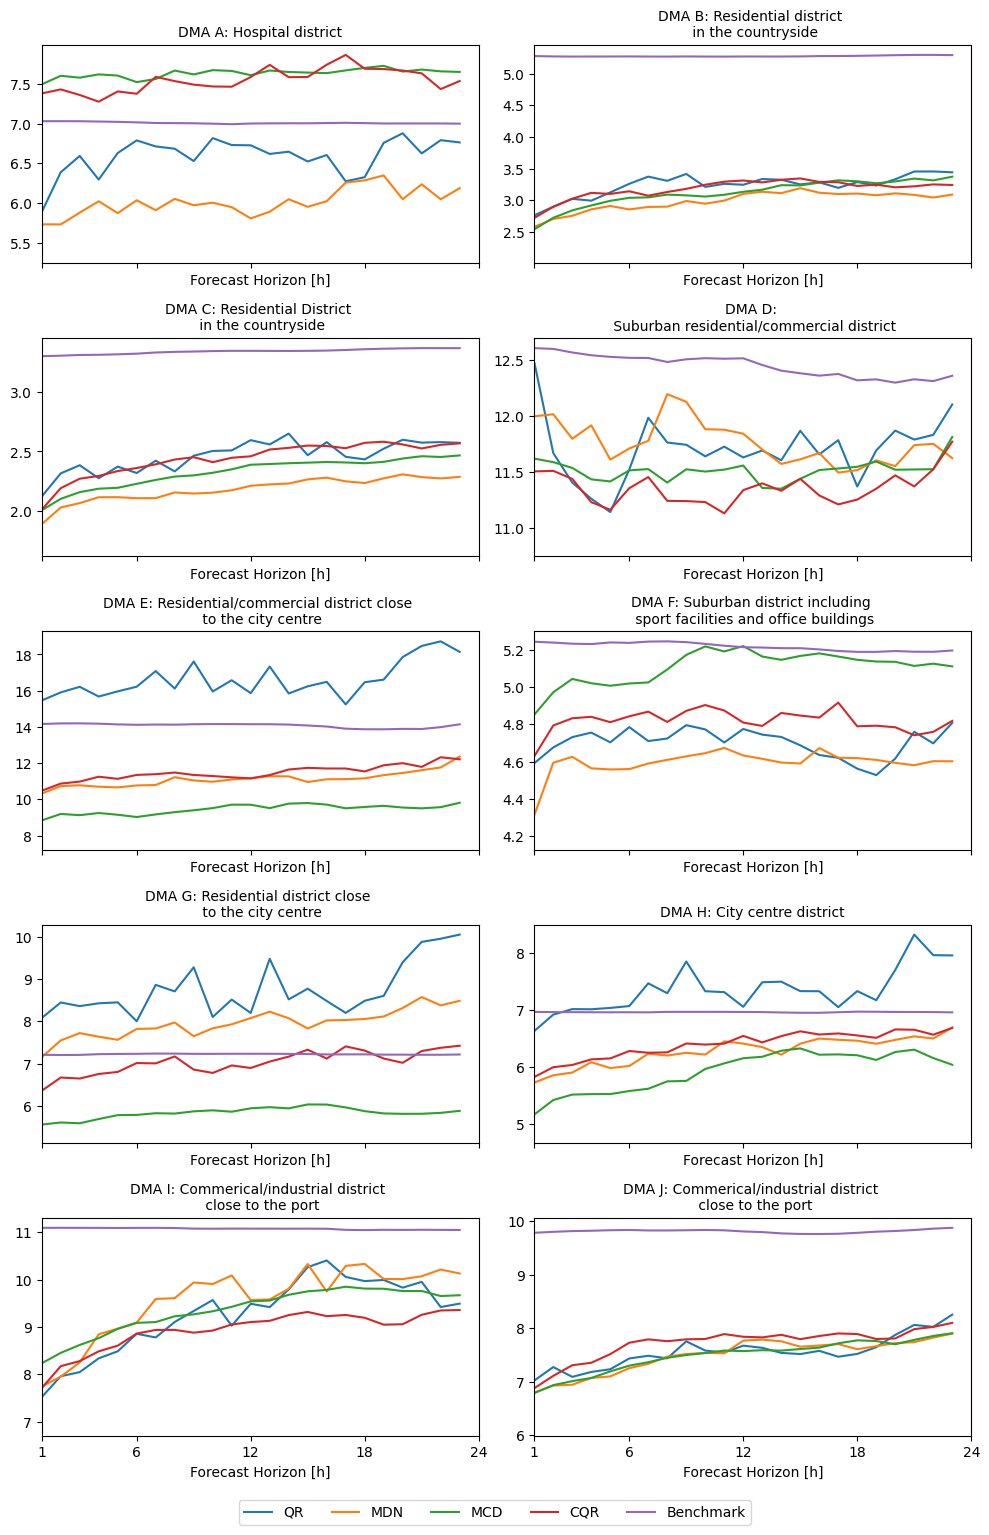

In [82]:
# plot the 2d winkler scores
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,15), sharex=True, sharey=False)
axs = ax.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i, ax in enumerate(axs):
    ax.plot(winkler_qrs_2d[i] , label='QR', color=colors[0])
    ax.plot(winkler_mdns_2d[i], label='MDN', color=colors[1])
    ax.plot(winkler_mcd_2d[i] , label='MCD', color=colors[2])
    ax.plot(winkler_cp_2d[i]  , label='CQR', color=colors[3])
    ax.plot(winkler_naive_2d[i], label='Benchmark', color=colors[4])
    # ax.axhline(1, color='black', linestyle='--', label='Benchmark Model')
    # ax.plot(winkler_naive_2d[i]//winkler_naive_2d[i], label='Benchmark', color=colors[4])
    # ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    ax.set_xticks([1, 6, 12, 18, 24])
    ax.set_xlim(1,24)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    # if i==0 or i==5:
    #     ax.set_ylabel('MAPE [%]')

    ax.set_xlabel('Forecast Horizon [h]')
    # ax.set_ylim(0, 1000)
    # ax.legend(['Model', 'Naive'])
    # ax.grid()

    
    # ax.legend()

# add legend in th ebottom
legend = fig.legend(['QR', 'MDN', 'MCD', 'CQR', 'Benchmark'], loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.025))
fig.tight_layout()
fig.savefig('../figures/winkler_2d.png', bbox_extra_artists=(legend,), bbox_inches='tight')

In [40]:
df_test_winkler.round(2). style.apply(color_min_max_subset).format("{:.2f}")#.to_latex()

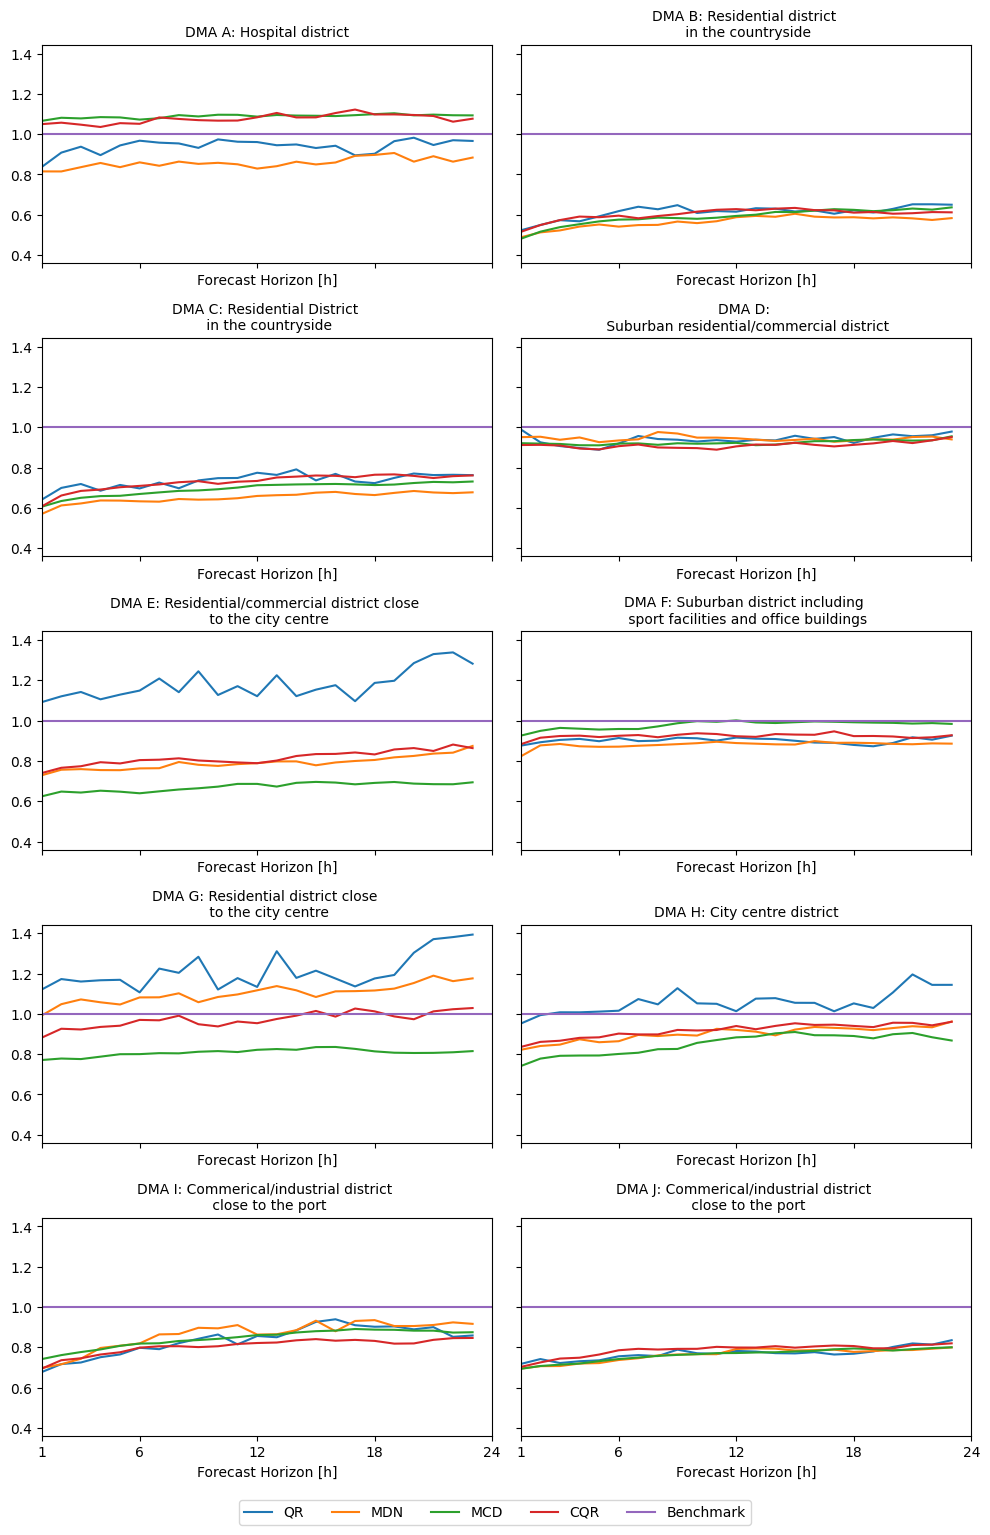

In [81]:
# plot the 2d winkler scores
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,15), sharex=True, sharey=True)
axs = ax.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i, ax in enumerate(axs):
    ax.plot(winkler_qrs_2d[i] /winkler_naive_2d[i], label='QR', color=colors[0])
    ax.plot(winkler_mdns_2d[i]/winkler_naive_2d[i], label='MDN', color=colors[1])
    ax.plot(winkler_mcd_2d[i] /winkler_naive_2d[i], label='MCD', color=colors[2])
    ax.plot(winkler_cp_2d[i]  /winkler_naive_2d[i], label='CQR', color=colors[3])
    ax.axhline(1, color='tab:purple', label='Benchmark Model')
    # ax.plot(winkler_naive_2d[i]//winkler_naive_2d[i], label='Benchmark', color=colors[4])
    # ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    ax.set_xticks([1, 6, 12, 18, 24])
    ax.set_xlim(1,24)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    # if i==0 or i==5:
    #     ax.set_ylabel('MAPE [%]')

    ax.set_xlabel('Forecast Horizon [h]')
    # ax.set_ylim(0, 1000)
    # ax.legend(['Model', 'Naive'])
    # ax.grid()

    
    # ax.legend()

# add legend in th ebottom
legend = fig.legend(['QR', 'MDN', 'MCD', 'CQR', 'Benchmark'], loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.025))
fig.tight_layout()

fig.savefig('../figures/winkler_2d_normalized_benchmark.png', bbox_extra_artists=(legend,), bbox_inches='tight')

In [42]:
# quantiles = [0.9899, 0.9865, 0.988]
# ind_dma_a = torch.load('../data/sequences/24h_out_all_no_weather/test_ind_24h_out_all_no_weather_A.pt')

# test_df = torch.load('../data/processed/test_df.pt')
# def indexer(indexlist, df, col):
#     min_index = indexlist[0]
#     max_index = indexlist[-1]
#     return torch.Tensor(df.loc[min_index:max_index, col].copy().to_numpy())

# test_df_a = test_df[['DMA A (L/s)']].copy()
# test_df_a = test_df_a.diff()
# diffeds = []

# split1 = '07-25-2022'
# split2 = '11-01-2022'

# for i, diffed_dma_a in enumerate([test_df_a.loc[:split1], test_df_a.loc[split1:split2], test_df_a.loc[split2:]]):
    
#     # diffed_dma_a = df_dma_a.diff()

#     diffed_dma_a['outliers'] = diffed_dma_a['DMA A (L/s)'] > diffed_dma_a['DMA A (L/s)'].quantile(quantiles[i])# * diffed_dma_a['DMA A (L/s)']

#     if i == 1:
#         diffed_dma_a['outliers'].iloc[0] = True
#     diffed_dma_a.loc[:,'outlier_val'] = diffed_dma_a['DMA A (L/s)'][diffed_dma_a['outliers']]

#     diffeds.append(diffed_dma_a)


# diffeds = pd.concat(diffeds)

# # diffeds['DMA A (L/s)'].plot(figsize=(20, 5), label='DMA A (L/s)', color=f'C{i}')
# # diffeds['outlier_val'].plot(figsize=(20, 5), color='r', marker='o', linestyle='None')

# diffeds = diffeds[~diffeds.index.duplicated(keep='first')]
# tensor_peaks_dma_a = torch.Tensor(np.array([indexer(ind, diffeds, 'outliers') for ind in ind_dma_a])).to(torch.bool)

# y_peaks_dma_a = y_test[0][tensor_peaks_dma_a]
# y_peaks_qr_up =  q_preds_qr[0][:,:,-1][tensor_peaks_dma_a]
# y_peaks_qr_low = q_preds_qr[0][:,:,0][tensor_peaks_dma_a]

# y_peaks_mdn_up =  q_preds_mdn[0][:,:,-1][tensor_peaks_dma_a]
# y_peaks_mdn_low = q_preds_mdn[0][:,:,0][tensor_peaks_dma_a]

# # 1d picp
# def comptue_picp_1d_input(y, up, low):
#     l = low
#     u = up

#     in_or_out = ((y >= l) & (y <= u)).to(torch.float32)
#     return in_or_out.mean()

# picp_qr = comptue_picp_1d_input(y_peaks_dma_a, y_peaks_qr_up, y_peaks_qr_low)
# picp_mdn = comptue_picp_1d_input(y_peaks_dma_a, y_peaks_mdn_up, y_peaks_mdn_low)

In [43]:

# compute the PICP between the weekend and the weekday
def compute_picp_weekend_weekday(q_preds, y_true):

    picp_weekends = []
    picp_weekdays = []
    for i, dma in enumerate(DMAs):
        test_data_dma_ind = torch.load(f'../data/sequences/24h_out_all_no_weather/test_ind_24h_out_all_no_weather_{dma}.pt', map_location='cpu')
        weekendornot = torch.Tensor([(tdma.tz_convert('Europe/Rome').weekday >=5) for tdma in test_data_dma_ind]).to(torch.bool)
        q_preds_dma = q_preds[i]
        
        q_preds_up = q_preds_dma[:, :, -1]
        q_preds_low = q_preds_dma[:, :, 0]
        y_true_dma = y_true[i]

        picp_weekend1 =  ((q_preds_up[weekendornot] >= y_true_dma[weekendornot]) & (q_preds_low[weekendornot] <= y_true_dma[weekendornot])).to(torch.float).mean().item()
        picp_weekday1 =  ((q_preds_up[~weekendornot] >= y_true_dma[~weekendornot]) & (q_preds_low[~weekendornot] <= y_true_dma[~weekendornot])).to(torch.float).mean().item()
        # print(picp_weekend)
        # print(picp_weekday)
        picp_weekends.append(picp_weekend1)
        picp_weekdays.append(picp_weekday1)
                         
    return picp_weekends, picp_weekdays

picp_weekend = []
picp_weekday = []
q_preds_naive_normed = [(qp-scale2)/scale1 for qp, scale1, scale2 in zip(q_preds_naive, scale1s, scale2s)]
for q_preds in [q_preds_qr, q_preds_mdn, q_preds_mcd, q_preds_cp, q_preds_naive_normed]:
    p_end, p_day = compute_picp_weekend_weekday(q_preds, y_test)
    picp_weekend.append(p_end)
    picp_weekday.append(p_day)
    # break

/tmp/ipykernel_3959/3580470830.py:8: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)



In [44]:
df_picp_weekday = pd.DataFrame({'QR': picp_weekday[0], 'MDN': picp_weekday[1], 'MCD': picp_weekday[2], 'CQR': picp_weekday[3], 'Benchmark Model': picp_weekday[4]}, index=DMAs).T
df_picp_weekend = pd.DataFrame({'QR': picp_weekend[0], 'MDN': picp_weekend[1], 'MCD': picp_weekend[2], 'CQR': picp_weekend[3], 'Benchmark Model': picp_weekend[4]}, index=DMAs).T

In [154]:
df_picp_weekday.round(2).style.apply(color_min_max_subset, axis=0).format("{:.2f}")


In [155]:
df_picp_weekend.round(2).style.apply(color_min_max_subset, axis=0).format("{:.2f}")


In [156]:
df_picp_weekend_weekday = (df_picp_weekend - df_picp_weekday)
df_picp_weekend_weekday['Average Abs. Difference'] = df_picp_weekend_weekday.abs().mean(axis=1)
df_picp_weekend_weekday['Max Abs. Difference'] = df_picp_weekend_weekday.abs().max(axis=1)
df_picp_weekend_weekday_style = df_picp_weekend_weekday.sort_values('Average Abs. Difference').round(2).style.apply(show_closest_00_green, axis=0).apply(show_farthest_00_red, axis=0).format("{:.2f}")
df_picp_weekend_weekday_style

In [157]:
df_picp_weekend_weekday_style.to_latex()

'\\begin{tabular}{lrrrrrrrrrrrr}\n & A & B & C & D & E & F & G & H & I & J & Average Abs. Difference & Max Abs. Difference \\\\\nQR & \\background-color#d9ecd9 \\font-weightbold 0.01 & \\background-color#ffd3d3 \\font-weightbold -0.02 & \\background-color#ffd3d3 \\font-weightbold -0.01 & 0.02 & \\background-color#d9ecd9 \\font-weightbold -0.00 & 0.01 & \\background-color#d9ecd9 \\font-weightbold -0.00 & 0.01 & 0.02 & 0.02 & \\background-color#d9ecd9 \\font-weightbold 0.01 & \\background-color#d9ecd9 \\font-weightbold 0.02 \\\\\nCQR & 0.02 & \\background-color#d9ecd9 \\font-weightbold -0.01 & \\background-color#ffd3d3 \\font-weightbold 0.01 & 0.01 & -0.03 & 0.02 & \\background-color#ffd3d3 \\font-weightbold -0.01 & -0.02 & \\background-color#d9ecd9 \\font-weightbold 0.01 & \\background-color#d9ecd9 \\font-weightbold 0.00 & \\background-color#d9ecd9 \\font-weightbold 0.01 & 0.03 \\\\\nMCD & 0.02 & \\background-color#ffd3d3 \\font-weightbold -0.02 & \\background-color#ffd3d3 \\font-weight

In [85]:
q_preds_naive_unnormed = [(qp-scale2)/scale1 for qp, scale1, scale2 in zip(q_preds_naive, scale1s, scale2s)]

In [86]:
qr_rolling_picp = []
qr_rolling_robust_pinaw = []
qr_rolling_winkler = []

mdn_rolling_picp = []
mdn_rolling_robust_pinaw = []
mdn_rolling_winkler = []

mcd_rolling_picp = []
mcd_rolling_robust_pinaw = []
mcd_rolling_winkler = []

cp_rolling_picp = []
cp_rolling_robust_pinaw = []
cp_rolling_winkler = []

naive_rolling_picp = []
naive_rolling_robust_pinaw = [] 
naive_rolling_winkler = []

rolling_window = 168
alpha = 0.05

q_preds = [q_preds_qr, q_preds_mdn, q_preds_mcd, q_preds_cp, q_preds_naive_unnormed]
for j, q_pred in enumerate(q_preds):
    for i, dma in enumerate(DMAs): 

        ds = '24h_out_all_no_weather'
        data_folder = '../data/sequences/'
        test_data_dma_ind = torch.load(f'../data/sequences/24h_out_all_no_weather/test_ind_24h_out_all_no_weather_{DMAs[i]}.pt', map_location='cpu')

        df_ind_dma = pd.DataFrame(test_data_dma_ind) #new_index = pd.date_range(start=index[0], end=index[-interval_length], freq='h')
        df_ind_dma.index = df_ind_dma[0]
        old_index = df_ind_dma.index
        df_low = pd.DataFrame(q_pred[i][:,:,0])
        df_high = pd.DataFrame(q_pred[i][:,:,2])
        print(i)
        df_low.index = old_index
        df_high.index = old_index
        new_index = pd.date_range(start=df_ind_dma.index[0], end=df_ind_dma.index[-1], freq='h')
        df_low= df_low.reindex(new_index)
        df_high = df_high.reindex(new_index)
        df_y_test = pd.DataFrame(y_test[i])
        df_y_test.index = old_index
        df_y_test = df_y_test.reindex(new_index)
        for col, col, col in zip(df_low.columns, df_high.columns, df_y_test.columns):
            df_low[col] = df_low[col].shift(col)
            df_high[col] = df_high[col].shift(col)
            df_y_test[col] = df_y_test[col].shift(col)
        df_low = df_low.dropna()
        df_high = df_high.dropna()
        df_y_test = df_y_test.dropna()


        # picp
        df_picp_rolling = ((df_low<df_y_test) & (df_high>df_y_test)*1).mean(axis=1)
        df_rolling_count = df_picp_rolling.reindex(new_index).rolling(rolling_window).count()

        df_picp_rolling = df_picp_rolling.reindex(new_index).rolling(rolling_window).mean()
        df_picp_rolling = df_picp_rolling[df_rolling_count==rolling_window]
        df_picp_rolling = df_picp_rolling.reindex(new_index)

        # # robust pinaw
        # df_width_rolling = (df_high - df_low).mean(axis=1)
        # df_rolling_count = df_width_rolling.reindex(new_index).rolling(rolling_window).count()

        # df_width_rolling = df_width_rolling.reindex(new_index).rolling(rolling_window).mean()
        # df_iqr_rolling = df_y_test.reindex(new_index).rolling(rolling_window).apply(lambda x: x.quantile(0.75) - x.quantile(0.25))
        # df_robust_pinaw_rolling = df_width_rolling / df_iqr_rolling
        # df_robust_pinaw_rolling = df_robust_pinaw_rolling[df_rolling_count==rolling_window]
        # df_robust_pinaw_rolling = df_robust_pinaw_rolling.reindex(new_index)

        # # winkler formula (u-l + (2/alpha)*(l-y)*(y<l) + (2/alpha)*(y-u)*(y>u))
        # df_winkler_rolling = (df_width_rolling + (2/alpha)*(df_low - df_y_test)*(df_y_test<df_low) + (2/alpha)*(df_y_test - df_high)*(df_y_test>df_high)).mean(axis=1)
        # df_rolling_count = df_winkler_rolling.reindex(new_index).rolling(rolling_window).count()


        # df_winkler_rolling = df_winkler_rolling.reindex(new_index).rolling(rolling_window).mean()
        # df_winkler_rolling = df_winkler_rolling[df_rolling_count==rolling_window]
        # df_winkler_rolling = df_winkler_rolling.reindex(new_index)
        
        
        if j==0:
            qr_rolling_picp.append(df_picp_rolling)
            # qr_rolling_robust_pinaw.append(df_robust_pinaw_rolling)
            # qr_rolling_winkler.append(df_winkler_rolling)
        if j==1:
            mdn_rolling_picp.append(df_picp_rolling)
            # mdn_rolling_robust_pinaw.append(df_robust_pinaw_rolling)
            # mdn_rolling_winkler.append(df_winkler_rolling)
        if j==2:
            mcd_rolling_picp.append(df_picp_rolling)
            # mcd_rolling_robust_pinaw.append(df_robust_pinaw_rolling)
            # mcd_rolling_winkler.append(df_winkler_rolling)  
        if j==3:
            cp_rolling_picp.append(df_picp_rolling)
            # cp_rolling_robust_pinaw.append(df_robust_pinaw_rolling)
            # cp_rolling_winkler.append(df_winkler_rolling)
        if j==4:
            naive_rolling_picp.append(df_picp_rolling)
            # naive_rolling_robust_pinaw.append(df_robust_pinaw_rolling)
            # naive_rolling_winkler.append(df_winkler_rolling)

    #     break
    # break

    



0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


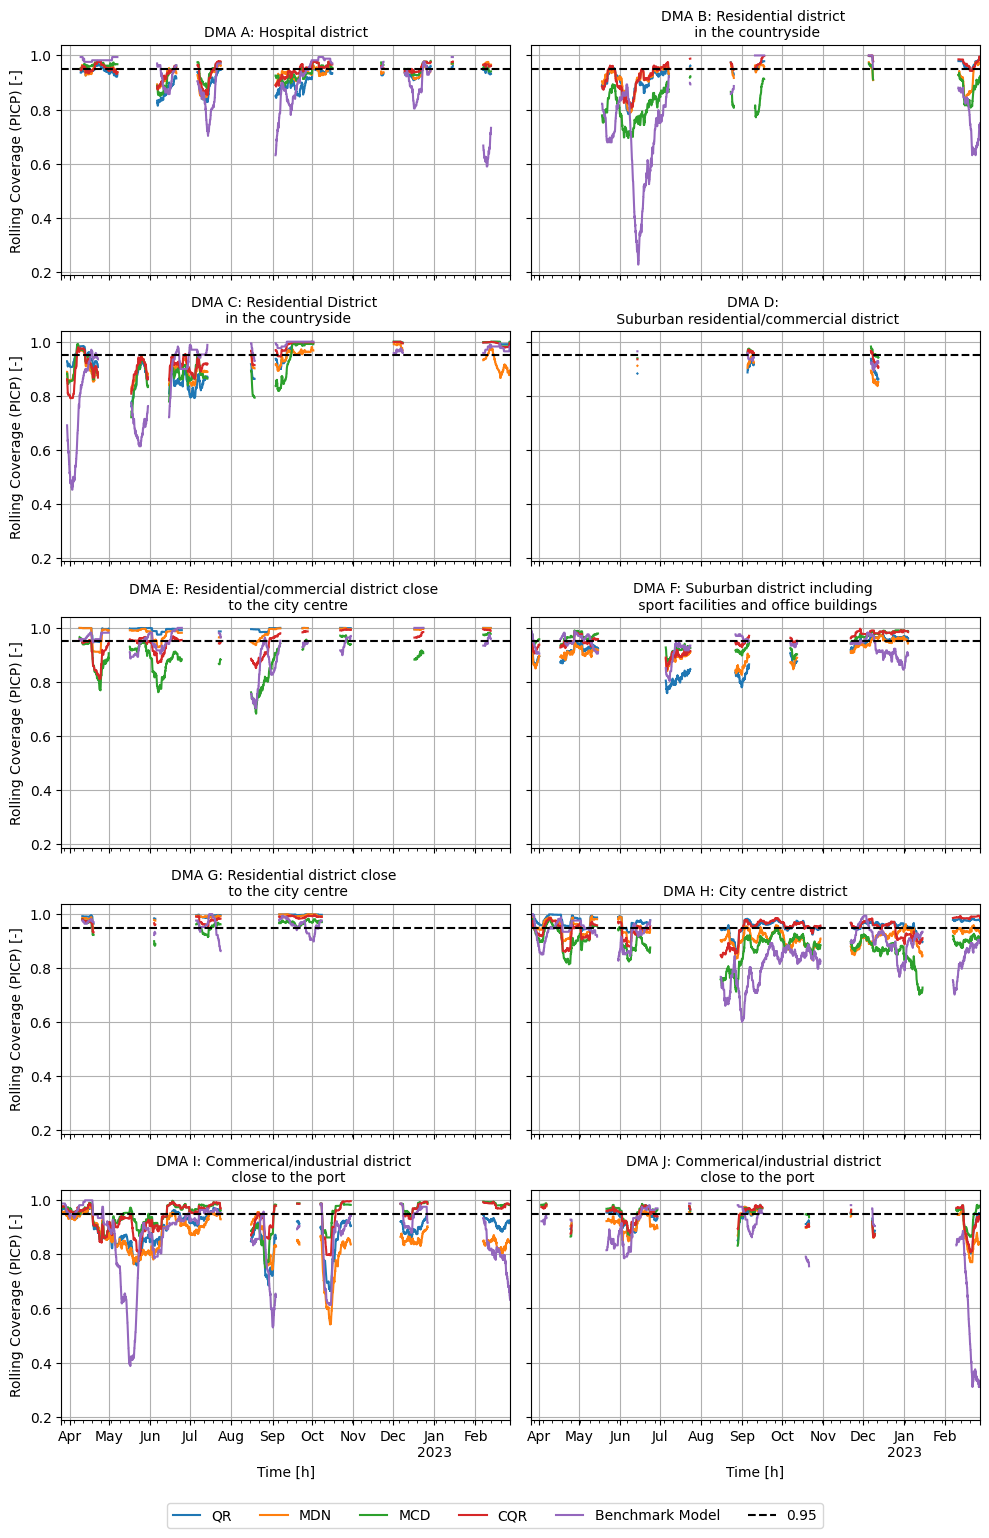

In [134]:
    
fig1, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,15), sharex=True, sharey=True)
axs1 = ax.flatten()

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


for i, (ax1, 
        qr_rolling_picp_i, mdn_rolling_picp_i, mcd_rolling_picp_i, cp_rolling_picp_i, naive_rolling_picp_i) in enumerate(zip(axs1,
        qr_rolling_picp, mdn_rolling_picp, mcd_rolling_picp, cp_rolling_picp, naive_rolling_picp)):
    
    ax1.set_title(new_column_names_with_newlines[i], fontsize=10)

    qr_rolling_picp_i.plot(ax=ax1, color=colors[0])
    mdn_rolling_picp_i.plot(ax=ax1, color=colors[1])
    mcd_rolling_picp_i.plot(ax=ax1, color=colors[2])
    cp_rolling_picp_i.plot(ax=ax1, color=colors[3])
    naive_rolling_picp_i.plot(ax=ax1, color=colors[4])
    ax1.axhline(0.95, color='black', linestyle='--')


    #labels at right plots
    if i % 2 == 0:
        ax1.set_ylabel('Rolling Coverage (PICP) [-]')

    # ax show grid
    ax1.grid()
    if i > 6:
        ax1.set_xlabel('Time [h]')


legend = fig1.legend(['QR', 'MDN', 'MCD', 'CQR', 'Benchmark Model', '0.95'], loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.027))
fig1.tight_layout()
# fig1.savefig()

fig1.savefig('../figures/rolling_picp_all.png', bbox_extra_artists=(legend,), bbox_inches='tight')

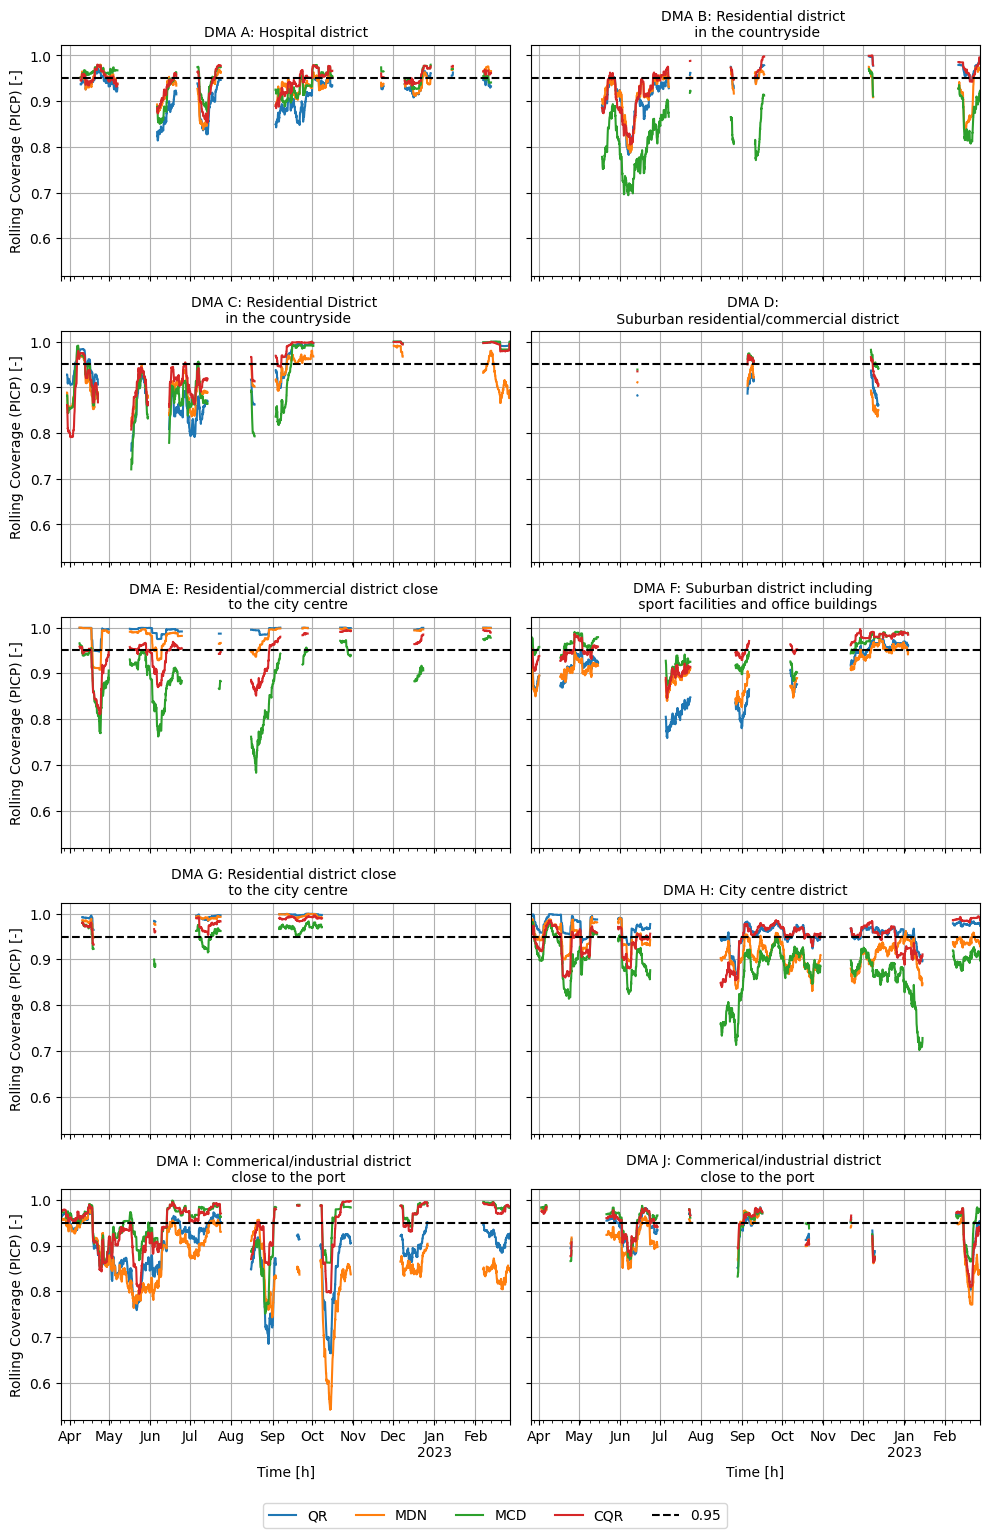

In [135]:
    
fig1, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,15), sharex=True, sharey=True)
axs1 = ax.flatten()

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


for i, (ax1, 
        qr_rolling_picp_i, mdn_rolling_picp_i, mcd_rolling_picp_i, cp_rolling_picp_i, naive_rolling_picp_i) in enumerate(zip(axs1,
        qr_rolling_picp, mdn_rolling_picp, mcd_rolling_picp, cp_rolling_picp, naive_rolling_picp)):
    
    ax1.set_title(new_column_names_with_newlines[i], fontsize=10)

    qr_rolling_picp_i.plot(ax=ax1, color=colors[0])
    mdn_rolling_picp_i.plot(ax=ax1, color=colors[1])
    mcd_rolling_picp_i.plot(ax=ax1, color=colors[2])
    cp_rolling_picp_i.plot(ax=ax1, color=colors[3])
    # naive_rolling_picp_i.plot(ax=ax1, color=colors[4])
    ax1.axhline(0.95, color='black', linestyle='--')


    #labels at right plots
    if i % 2 == 0:
        ax1.set_ylabel('Rolling Coverage (PICP) [-]')

    # ax show grid
    ax1.grid()
    if i > 6:
        ax1.set_xlabel('Time [h]')


legend = fig1.legend(['QR', 'MDN', 'MCD', 'CQR', '0.95'], loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.027))
fig1.tight_layout()
# fig1.savefig()

fig1.savefig('../figures/rolling_picp_all_no_benchmark.png', bbox_extra_artists=(legend,), bbox_inches='tight')

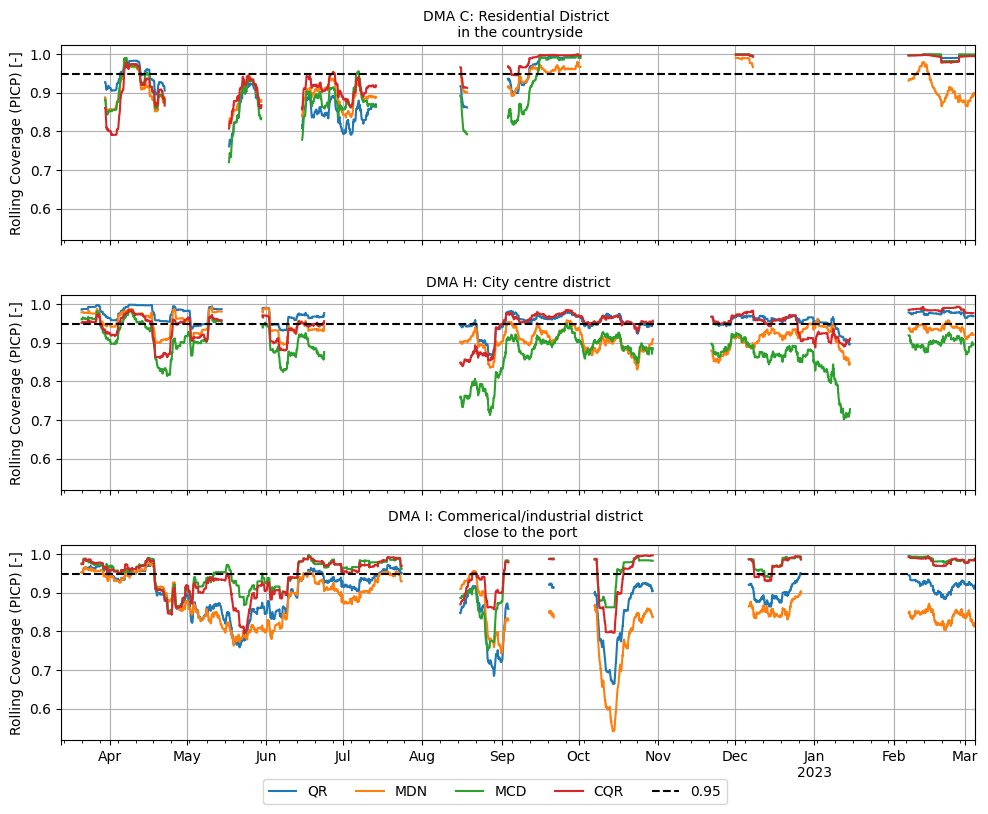

In [89]:

fig1, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,8), sharex=True, sharey=True)
axs1 = ax.flatten()

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

iis=[2,7,8]
for i, ax1 in enumerate(axs1):
    i = iis[i]
    ax1.set_title(new_column_names_with_newlines[i], fontsize=10)

    qr_rolling_picp_i = qr_rolling_picp[i]
    mdn_rolling_picp_i = mdn_rolling_picp[i]
    mcd_rolling_picp_i = mcd_rolling_picp[i]
    cp_rolling_picp_i = cp_rolling_picp[i]
    naive_rolling_picp_i = naive_rolling_picp[i]

    qr_rolling_picp_i.plot(ax=ax1, color=colors[0])
    mdn_rolling_picp_i.plot(ax=ax1, color=colors[1])
    mcd_rolling_picp_i.plot(ax=ax1, color=colors[2])
    cp_rolling_picp_i.plot(ax=ax1, color=colors[3])
    # naive_rolling_picp_i.plot(ax=ax1, color=colors[4])
    ax1.axhline(0.95, color='black', linestyle='--')

    #labels at right plots
    ax1.set_ylabel('Rolling Coverage (PICP) [-]')

    # ax show grid
    ax1.grid()


legend = fig1.legend(['QR', 'MDN', 'MCD', 'CQR', '0.95'], loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.02))
fig1.tight_layout()
fig1.savefig('../figures/rolling_picp_small.png', bbox_extra_artists=(legend,), bbox_inches='tight')

In [208]:
df_test_mins_picp = pd.DataFrame(
    {'QR': [qr_rolling_picp_i.min() for qr_rolling_picp_i in qr_rolling_picp],
     'MDN': [mdn_rolling_picp_i.min() for mdn_rolling_picp_i in mdn_rolling_picp],
     'MCD': [mcd_rolling_picp_i.min() for mcd_rolling_picp_i in mcd_rolling_picp],
     'CQR': [cp_rolling_picp_i.min() for cp_rolling_picp_i in cp_rolling_picp],
     'Benchmark': [naive_rolling_picp_i.min() for naive_rolling_picp_i in naive_rolling_picp]}, index=DMAs).T
df_test_mins_picp['Average CG'] = (df_test_mins_picp-0.95).abs().mean(axis=1)
df_test_mins_picp['Median CG'] = (df_test_mins_picp-0.95).abs().median(axis=1)
df_test_mins_picp['Min'] = df_test_mins_picp[DMAs].min(axis=1)
df_test_mins_picp['Max'] = df_test_mins_picp[DMAs].max(axis=1)

df_test_maxs_picp = pd.DataFrame(
    {'QR': [qr_rolling_picp_i.max() for qr_rolling_picp_i in qr_rolling_picp],
     'MDN': [mdn_rolling_picp_i.max() for mdn_rolling_picp_i in mdn_rolling_picp],
     'MCD': [mcd_rolling_picp_i.max() for mcd_rolling_picp_i in mcd_rolling_picp],
     'CQR': [cp_rolling_picp_i.max() for cp_rolling_picp_i in cp_rolling_picp],
     'Benchmark': [naive_rolling_picp_i.max() for naive_rolling_picp_i in naive_rolling_picp]}, index=DMAs).T
df_test_maxs_picp['Average CG'] = (df_test_maxs_picp-0.95).abs().mean(axis=1)
df_test_maxs_picp['Median CG'] = (df_test_maxs_picp-0.95).abs().median(axis=1)
df_test_maxs_picp['Min'] = df_test_maxs_picp[DMAs].min(axis=1)
df_test_maxs_picp['Max'] = df_test_maxs_picp[DMAs].max(axis=1)

df_test_means_picp = pd.DataFrame(
    {'QR': [qr_rolling_picp_i.mean() for qr_rolling_picp_i in qr_rolling_picp],
     'MDN': [mdn_rolling_picp_i.mean() for mdn_rolling_picp_i in mdn_rolling_picp],
     'MCD': [mcd_rolling_picp_i.mean() for mcd_rolling_picp_i in mcd_rolling_picp],
     'CQR': [cp_rolling_picp_i.mean() for cp_rolling_picp_i in cp_rolling_picp],
     'Benchmark': [naive_rolling_picp_i.mean() for naive_rolling_picp_i in naive_rolling_picp]}, index=DMAs).T
df_test_means_picp['Average CG'] = (df_test_means_picp-0.95).abs().mean(axis=1)
df_test_means_picp['Median CG'] = (df_test_means_picp-0.95).abs().median(axis=1)
df_test_means_picp['Min'] = df_test_means_picp[DMAs].min(axis=1)
df_test_means_picp['Max'] = df_test_means_picp[DMAs].max(axis=1)

df_test_medians_picp = pd.DataFrame(
    {'QR': [qr_rolling_picp_i.median() for qr_rolling_picp_i in qr_rolling_picp],
     'MDN': [mdn_rolling_picp_i.median() for mdn_rolling_picp_i in mdn_rolling_picp],
     'MCD': [mcd_rolling_picp_i.median() for mcd_rolling_picp_i in mcd_rolling_picp],
     'CQR': [cp_rolling_picp_i.median() for cp_rolling_picp_i in cp_rolling_picp],
     'Benchmark': [naive_rolling_picp_i.median() for naive_rolling_picp_i in naive_rolling_picp]}, index=DMAs).T
df_test_medians_picp['Average CG'] = (df_test_medians_picp-0.95).abs().mean(axis=1)
df_test_medians_picp['Median CG'] = (df_test_medians_picp-0.95).abs().median(axis=1)
df_test_medians_picp['Min'] = df_test_medians_picp[DMAs].min(axis=1)
df_test_medians_picp['Max'] = df_test_medians_picp[DMAs].max(axis=1)


In [209]:
df_test_mins_picp

A         B         C         D         E         F  \
QR         0.813988  0.782738  0.761409  0.859623  0.947669  0.758433   
MDN        0.838046  0.787450  0.815724  0.835565  0.907986  0.826141   
MCD        0.850446  0.694444  0.720486  0.938740  0.682540  0.874504   
CQR        0.853175  0.805060  0.790923  0.902282  0.810268  0.845486   
Benchmark  0.589286  0.226190  0.452381  0.892857  0.702381  0.803571   

                  G         H         I         J  Average CG  Median CG  \
QR         0.964534  0.868552  0.664187  0.803571    0.130437   0.146429   
MDN        0.947669  0.830853  0.541419  0.770833    0.139831   0.123859   
MCD        0.883433  0.701885  0.750992  0.831845    0.157068   0.199008   
CQR        0.932044  0.839534  0.794147  0.809276    0.111781   0.139732   
Benchmark  0.863095  0.601190  0.386905  0.309524    0.367262   0.360714   

                Min       Max  
QR         0.664187  0.964534  
MDN        0.541419  0.947669  
MCD        0.682540  0.938740  
CQR        0.790923  0.932044  
Benchmark  0.226190  0.892857

In [210]:
# Assuming the provided DataFrames are already defined as:
# df_test_mins_picp, df_test_maxs_picp, df_test_means_picp, df_test_medians_picp

# Create a list of the models
models = ['QR', 'MDN', 'MCD', 'CQR', 'Benchmark']

# Create a list of the statistics
statistics = ['Min', 'Max']#, 'Median', 'Mean']



# Define the district names
districts = df_test_mins_picp.columns

rows_closest_to_095 = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'Min', 'Max']
rows_closest_to_00 = ['Average CG', 'Median CG']

# Create a MultiIndex for the columns
multi_columns = pd.MultiIndex.from_product([statistics, models], names=['Statistic', 'DMA'])

# Create an empty DataFrame with the MultiIndex columns and district names as the index
combined_df = pd.DataFrame(index=districts, columns=multi_columns)

# Fill in the combined DataFrame with the appropriate values
for stat, df in zip(statistics, [df_test_mins_picp, df_test_maxs_picp]):#, df_test_medians_picp, df_test_means_picp]):
    for model in models:
        combined_df[(stat, model)] = df.loc[model].values

# Function to apply bold formatting to the value closest to 0.95 for each statistic in each row
def highlight_stat_per_stat(row):
    styles = pd.Series('', index=row.index)

    if row.name in rows_closest_to_095:
        for stat in statistics:

            stat_columns = row[row.index.get_level_values('Statistic') == stat]

            closest_idx = (stat_columns - 0.95).abs().idxmin()
            styles[closest_idx] = 'font-weight: bold'
    else:
        for stat in statistics:
            # Find the index of the value closest to 0.95
            stat_columns = row[row.index.get_level_values('Statistic') == stat]
            closest_idx = stat_columns.idxmin()
            styles[closest_idx] = 'font-weight: bold'

    return styles



# Apply the highlighting function to each row
styled_df = combined_df.style.apply(highlight_stat_per_stat, axis=1).format("{:.2f}")

# Display the styled DataFrame
css = [
    # dict(selector="th", props=[("border-style", "solid"), ("border-width", "1px")]),
    dict(selector=".col0", props=[("border-left", "2px solid black")]), # Min group
    dict(selector=".col5", props=[("border-left", "2px solid black")]), # Max group
    dict(selector=".col10", props=[("border-left", "2px solid black")]), # Median group
    dict(selector=".col15", props=[("border-left", "2px solid black")]) # Mean group
]

# Apply the custom CSS to the styled DataFrame
styled_df_css = styled_df.set_table_styles(css)

# Display the styled DataFrame with borders between multi-columns
styled_df_css

In [211]:
print(format_styled_latex_table_with_booktabs(styled_df=styled_df, caption='Minimum and Maximum Statistics of Rolling PICP on all DMAs [-]'))

\begin{table}[H]
\caption{Minimum and Maximum Statistics of Rolling PICP on all DMAs [-]}
\label{table: Minimum and Maximum Statistics of Rolling PICP on all DMAs [-]}
\centering
\resizebox{\textwidth}{!}{%
\begin{table}
\.col02px solid black
\.col52px solid black
\.col102px solid black
\.col152px solid black
\begin{tabular}{lrrrrrrrrrr}
\toprule
Statistic & \multicolumn{5}{r}{Min} & \multicolumn{5}{r}{Max} \\
DMA & QR & MDN & MCD & CQR & Benchmark & QR & MDN & MCD & CQR & Benchmark \\
\midrule
A & 0.81 & 0.84 & 0.85 & \textbf{0.85} & 0.59 & \textbf{0.97} & 0.98 & 0.98 & 0.98 & 0.99 \\
B & 0.78 & 0.79 & 0.69 & \textbf{0.81} & 0.23 & 1.00 & 0.98 & \textbf{0.97} & 1.00 & 1.00 \\
C & 0.76 & \textbf{0.82} & 0.72 & 0.79 & 0.45 & 1.00 & \textbf{0.99} & 1.00 & 1.00 & 1.00 \\
D & 0.86 & 0.84 & \textbf{0.94} & 0.90 & 0.89 & 0.94 & \textbf{0.95} & 0.98 & 0.97 & 0.96 \\
E & \textbf{0.95} & 0.91 & 0.68 & 0.81 & 0.70 & 1.00 & 1.00 & \textbf{0.99} & 0.99 & 1.00 \\
F & 0.76 & 0.83 & \textbf{0.87} & 0

In [212]:
# Assuming the provided DataFrames are already defined as:
# df_test_mins_picp, df_test_maxs_picp, df_test_means_picp, df_test_medians_picp

# Create a list of the models
models = ['QR', 'MDN', 'MCD', 'CQR', 'Benchmark']

# Create a list of the statistics
statistics = ['Median', 'Mean']

# Define the district names
districts = df_test_mins_picp.columns

rows_closest_to_095 = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'Min', 'Max']
rows_closest_to_00 = ['Average CG', 'Median CG']

# Create a MultiIndex for the columns
multi_columns = pd.MultiIndex.from_product([statistics, models], names=['Statistic', 'DMA'])

# Create an empty DataFrame with the MultiIndex columns and district names as the index
combined_df = pd.DataFrame(index=districts, columns=multi_columns)

# Fill in the combined DataFrame with the appropriate values
for stat, df in zip(statistics, [df_test_medians_picp, df_test_means_picp]):#, df_test_medians_picp, df_test_means_picp]):
    for model in models:
        combined_df[(stat, model)] = df.loc[model].values

# Function to apply bold formatting to the value closest to 0.95 for each statistic in each row
def highlight_stat_per_stat(row):
    styles = pd.Series('', index=row.index)

    if row.name in rows_closest_to_095:
        for stat in statistics:

            stat_columns = row[row.index.get_level_values('Statistic') == stat]

            closest_idx = (stat_columns - 0.95).abs().idxmin()
            styles[closest_idx] = 'font-weight: bold'
    else:
        for stat in statistics:
            # Find the index of the value closest to 0.95
            stat_columns = row[row.index.get_level_values('Statistic') == stat]
            closest_idx = stat_columns.idxmin()
            styles[closest_idx] = 'font-weight: bold'

    return styles



# Apply the highlighting function to each row
styled_df = combined_df.style.apply(highlight_stat_per_stat, axis=1).format("{:.2f}")

# Display the styled DataFrame
css = [
    # dict(selector="th", props=[("border-style", "solid"), ("border-width", "1px")]),
    dict(selector=".col0", props=[("border-left", "2px solid black")]), # Min group
    dict(selector=".col5", props=[("border-left", "2px solid black")]), # Max group
    dict(selector=".col10", props=[("border-left", "2px solid black")]), # Median group
    dict(selector=".col15", props=[("border-left", "2px solid black")]) # Mean group
]

# Apply the custom CSS to the styled DataFrame
styled_df_css = styled_df.set_table_styles(css)
# Display the styled DataFrame with borders between multi-columns
display(styled_df_css)
print(format_styled_latex_table_with_booktabs(styled_df=styled_df, caption='Median and Mean Statistics of Rolling PICP on all DMAs [-]'))

\begin{table}[H]
\caption{Median and Mean Statistics of Rolling PICP on all DMAs [-]}
\label{table: Median and Mean Statistics of Rolling PICP on all DMAs [-]}
\centering
\resizebox{\textwidth}{!}{%
\begin{table}
\.col02px solid black
\.col52px solid black
\.col102px solid black
\.col152px solid black
\begin{tabular}{lrrrrrrrrrr}
\toprule
Statistic & \multicolumn{5}{r}{Median} & \multicolumn{5}{r}{Mean} \\
DMA & QR & MDN & MCD & CQR & Benchmark & QR & MDN & MCD & CQR & Benchmark \\
\midrule
A & 0.93 & 0.94 & \textbf{0.95} & 0.95 & 0.94 & 0.92 & 0.93 & 0.94 & \textbf{0.94} & 0.91 \\
B & 0.94 & 0.93 & 0.84 & \textbf{0.95} & 0.78 & 0.93 & 0.92 & 0.84 & \textbf{0.93} & 0.75 \\
C & \textbf{0.95} & 0.91 & 0.93 & 0.96 & 0.96 & 0.93 & 0.92 & 0.93 & \textbf{0.95} & 0.90 \\
D & 0.91 & 0.88 & 0.96 & \textbf{0.96} & 0.93 & 0.90 & 0.89 & 0.96 & \textbf{0.94} & 0.92 \\
E & 1.00 & 0.99 & 0.90 & 0.95 & \textbf{0.95} & 0.99 & 0.98 & 0.89 & \textbf{0.94} & 0.94 \\
F & 0.92 & 0.91 & 0.97 & \textbf{0.96} 

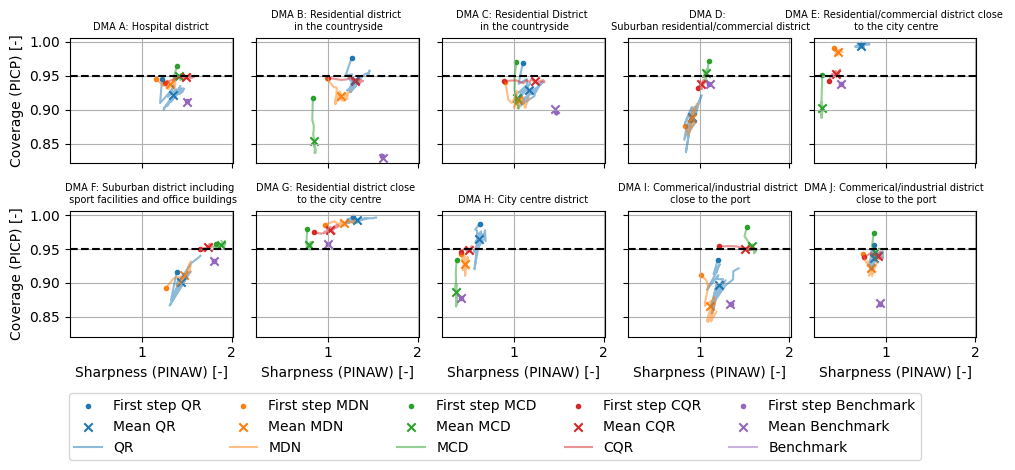

In [102]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True)
axs = ax.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# repeat every color in colors two times
colors = [color for color in colors for _ in (0, 1)]

# modelnames_prob = ['Mean QR', 'First step QR', 'QR', 'Mean MDN', 'First step MDN', 'MDN', 'Mean MCD', 'First step MCD', 'MCD', 'Mean CQR', 'First step CQR', 'CQR', 'Mean Benchmark', 'First step Benchmark', 'Benchmark']
modelnames_prob = ['First step QR', 'Mean QR', 'QR', 'First step MDN', 'Mean MDN', 'MDN', 'First step MCD', 'Mean MCD', 'MCD', 'First step CQR', 'Mean CQR', 'CQR', 'First step Benchmark', 'Mean Benchmark', 'Benchmark']

for i, (dma, ax) in enumerate(zip(DMAs, axs)):
    # Plot each model for the current DMA with the corresponding color
    # for j, model in enumerate(modelnames_prob):
        # ax.scatter(df_test_robust_pinaw[dma][model], df_test_picp[dma][model], color=colors[j], label=model)

    ax.scatter(mlp_qr_robust_pinaw_2d.iloc[0,i], mlp_qr_picp_2d.iloc[0,i], color=colors[0], label='First step QR', marker='.')
    ax.scatter(mlp_qr_robust_pinaw_2d.iloc[:,i].mean(), mlp_qr_picp_2d.iloc[:,i].mean(), color=colors[0], label='Mean QR', marker='x')
    ax.plot(mlp_qr_robust_pinaw_2d.iloc[:,i], mlp_qr_picp_2d.iloc[:,i], color=colors[1], label='QR', alpha=0.5)

    ax.scatter(mlp_mdn_robust_pinaw_2d.iloc[0,i], mlp_mdn_picp_2d.iloc[0,i], color=colors[2], label='First step MDN', marker='.')
    ax.scatter(mlp_mdn_robust_pinaw_2d.iloc[:,i].mean(), mlp_mdn_picp_2d.iloc[:,i].mean(), color=colors[2], label='Mean MDN', marker='x')
    ax.plot(mlp_mdn_robust_pinaw_2d.iloc[:,i], mlp_mdn_picp_2d.iloc[:,i], color=colors[3], label='MDN', alpha=0.5)

    ax.scatter(mlp_mcd_robust_pinaw_2d[i][0], mlp_mcd_picp_2d[i][0], color=colors[4], label='First step MCD', marker='.')
    ax.scatter(mlp_mcd_robust_pinaw_2d[i].mean(), mlp_mcd_picp_2d[i].mean(), color=colors[4], label='Mean MCD', marker='x')
    ax.plot(mlp_mcd_robust_pinaw_2d[i], mlp_mcd_picp_2d[i], color=colors[5], label='MCD', alpha=0.5)

    ax.scatter(mlp_cp_robust_pinaw_2d[i][0], mlp_cp_picp_2d[i][0], color=colors[6], label='First step CQR', marker='.')
    ax.scatter(mlp_cp_robust_pinaw_2d[i].mean(), mlp_cp_picp_2d[i].mean(), color=colors[6], label='Men CQR', marker='x')
    ax.plot(mlp_cp_robust_pinaw_2d[i], mlp_cp_picp_2d[i], color=colors[7], label='CQR', alpha=0.5)

    ax.scatter(naive_robust_pinaw_2d[i].mean(), naive_picp_2d[i].mean(), color=colors[8], label='First step Benchmark', marker='.')
    ax.scatter(naive_robust_pinaw_2d[i][0], naive_picp_2d[i][0], color=colors[8], label='Mean Benchmark', marker='x')
    ax.plot(naive_robust_pinaw_2d[i], naive_picp_2d[i], color=colors[9], label='Benchmark', alpha=0.5)



    # ax.plot()

    # ax.plot(mlp_qr_robust_pinaw_2d.iloc[:,i])
    # ax.plot(mlp_mdn_robust_pinaw_2d.iloc[:,i])


    # Set labels for rows and columns
    if i == 0 or i == 5:
        ax.set_ylabel('Coverage (PICP) [-]')
    else:
        ax.yaxis.set_tick_params(labelleft=False)

    if i >= 5:
        ax.set_xlabel('Sharpness (PINAW) [-]')
    else:
        ax.xaxis.set_tick_params(labelbottom=False)

    ax.axhline(0.95, color='black', linestyle='--')
    ax.grid()
    # ax.set_ylim(df_test_picp.min().min()*0.99, df_test_picp.max().max()*1.01)
    ax.set_title(new_column_names_with_newlines[i], fontsize=7)

# Create a legend with the model names and colors
legend = fig.legend(modelnames_prob, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.18))

fig.tight_layout()
# fig.savefig('../figures/2d_metrics_picp_robust_pinaw_all.png', bbox_extra_artists=(legend,), bbox_inches='tight')


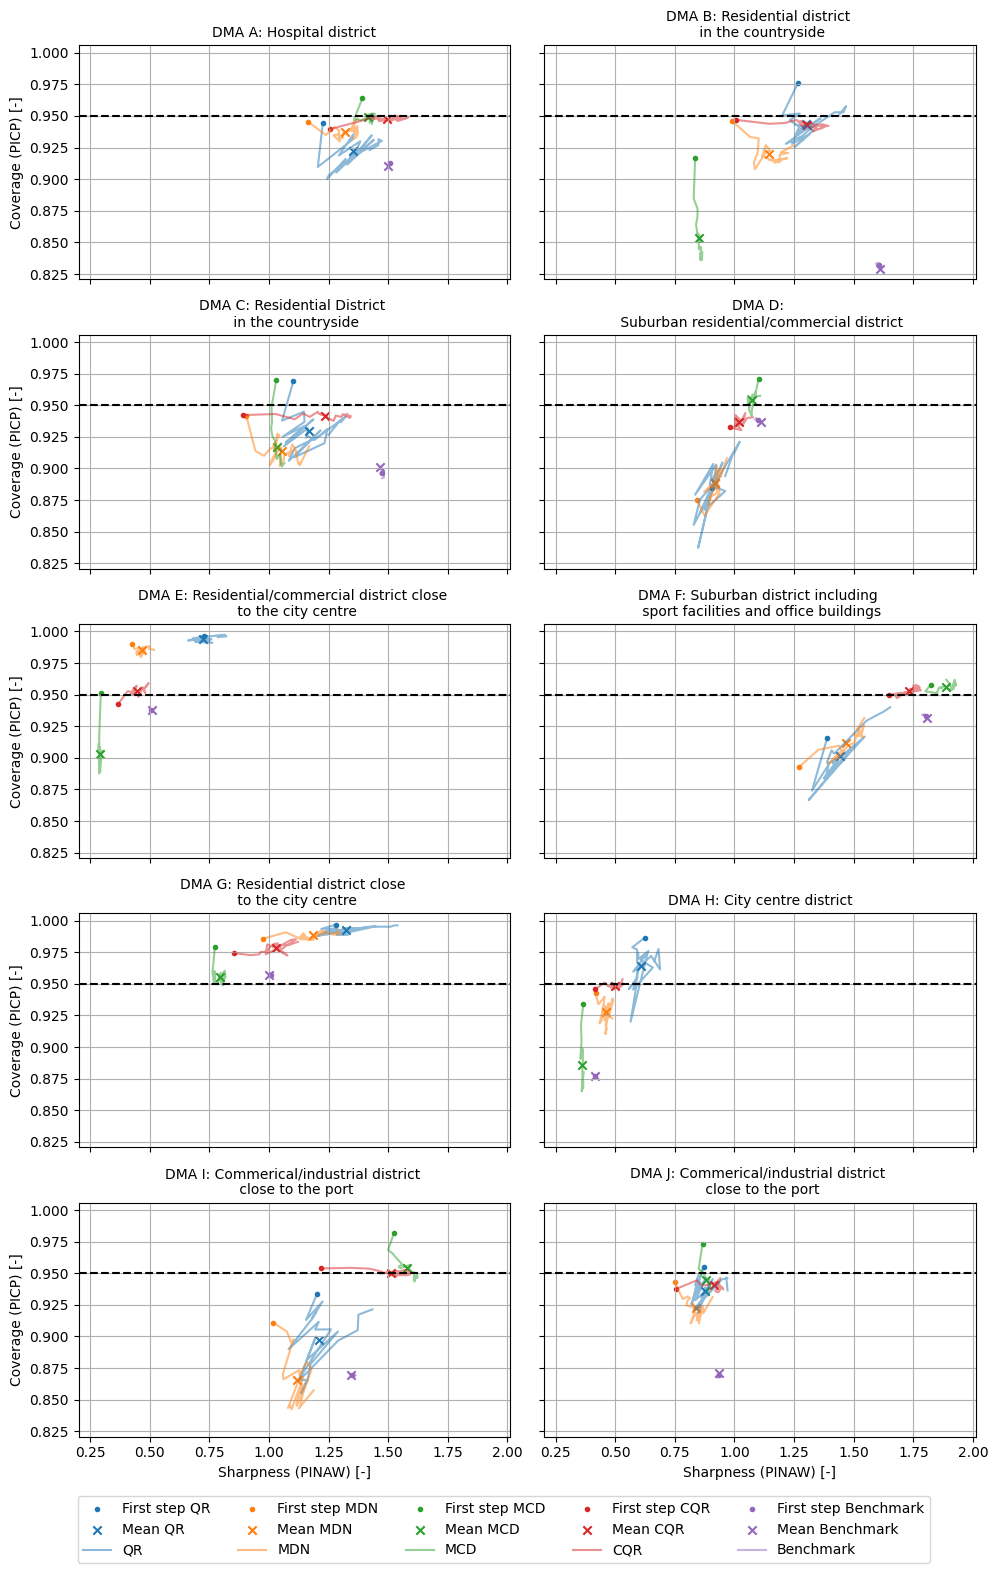

In [151]:
fig, ax = plt.subplots(5, 2, figsize=(10, 15), sharex=True, sharey=True)
axs = ax.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# repeat every color in colors two times
colors = [color for color in colors for _ in (0, 1)]

# modelnames_prob = ['Mean QR', 'First step QR', 'QR', 'Mean MDN', 'First step MDN', 'MDN', 'Mean MCD', 'First step MCD', 'MCD', 'Mean CQR', 'First step CQR', 'CQR', 'Mean Benchmark', 'First step Benchmark', 'Benchmark']
modelnames_prob = ['First step QR', 'Mean QR', 'QR', 'First step MDN', 'Mean MDN', 'MDN', 'First step MCD', 'Mean MCD', 'MCD', 'First step CQR', 'Mean CQR', 'CQR', 'First step Benchmark', 'Mean Benchmark', 'Benchmark']

for i, (dma, ax) in enumerate(zip(DMAs, axs)):

    ax.scatter(mlp_qr_robust_pinaw_2d.iloc[0,i], mlp_qr_picp_2d.iloc[0,i], color=colors[0], label='First step QR', marker='.')
    ax.scatter(mlp_qr_robust_pinaw_2d.iloc[:,i].mean(), mlp_qr_picp_2d.iloc[:,i].mean(), color=colors[0], label='Mean QR', marker='x')
    ax.plot(mlp_qr_robust_pinaw_2d.iloc[:,i], mlp_qr_picp_2d.iloc[:,i], color=colors[1], label='QR', alpha=0.5)

    ax.scatter(mlp_mdn_robust_pinaw_2d.iloc[0,i], mlp_mdn_picp_2d.iloc[0,i], color=colors[2], label='First step MDN', marker='.')
    ax.scatter(mlp_mdn_robust_pinaw_2d.iloc[:,i].mean(), mlp_mdn_picp_2d.iloc[:,i].mean(), color=colors[2], label='Mean MDN', marker='x')
    ax.plot(mlp_mdn_robust_pinaw_2d.iloc[:,i], mlp_mdn_picp_2d.iloc[:,i], color=colors[3], label='MDN', alpha=0.5)

    ax.scatter(mlp_mcd_robust_pinaw_2d[i][0], mlp_mcd_picp_2d[i][0], color=colors[4], label='First step MCD', marker='.')
    ax.scatter(mlp_mcd_robust_pinaw_2d[i].mean(), mlp_mcd_picp_2d[i].mean(), color=colors[4], label='Mean MCD', marker='x')
    ax.plot(mlp_mcd_robust_pinaw_2d[i], mlp_mcd_picp_2d[i], color=colors[5], label='MCD', alpha=0.5)

    ax.scatter(mlp_cp_robust_pinaw_2d[i][0], mlp_cp_picp_2d[i][0], color=colors[6], label='First step CQR', marker='.')
    ax.scatter(mlp_cp_robust_pinaw_2d[i].mean(), mlp_cp_picp_2d[i].mean(), color=colors[6], label='Men CQR', marker='x')
    ax.plot(mlp_cp_robust_pinaw_2d[i], mlp_cp_picp_2d[i], color=colors[7], label='CQR', alpha=0.5)

    ax.scatter(naive_robust_pinaw_2d[i].mean(), naive_picp_2d[i].mean(), color=colors[8], label='First step Benchmark', marker='.')
    ax.scatter(naive_robust_pinaw_2d[i][0], naive_picp_2d[i][0], color=colors[8], label='Mean Benchmark', marker='x')
    ax.plot(naive_robust_pinaw_2d[i], naive_picp_2d[i], color=colors[9], label='Benchmark', alpha=0.5)

    # Set labels for rows and columns
    if not (i%2):
        ax.set_ylabel('Coverage (PICP) [-]')
    else:
        ax.yaxis.set_tick_params(labelleft=False)

    if i >= 8:
        ax.set_xlabel('Sharpness (PINAW) [-]')
    else:
        ax.xaxis.set_tick_params(labelbottom=False)

    ax.axhline(0.95, color='black', linestyle='--')
    ax.grid()
    # ax.set_ylim(df_test_picp.min().min()*0.99, df_test_picp.max().max()*1.01)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)

# Create a legend with the model names and colors
legend = fig.legend(modelnames_prob, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05))

fig.tight_layout()
fig.savefig('../figures/2d_metrics_picp_robust_pinaw_all.png', bbox_extra_artists=(legend,), bbox_inches='tight')


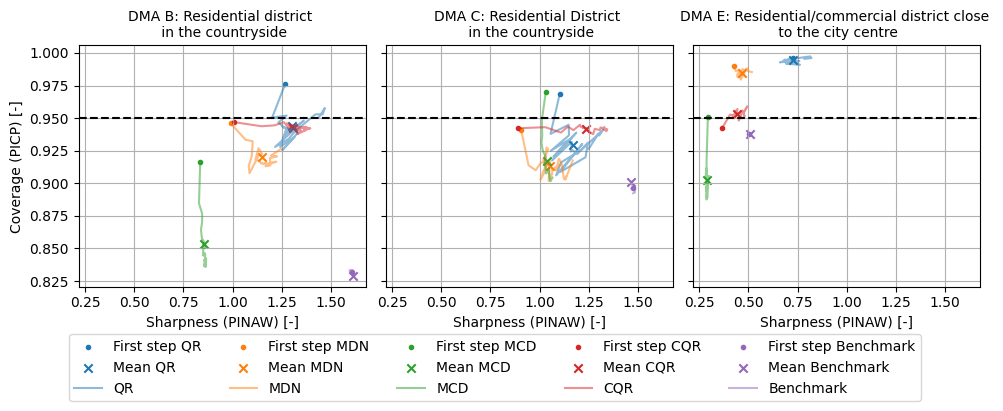

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3.5), sharex=True, sharey=True)
axs = ax.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# repeat every color in colors two times
colors = [color for color in colors for _ in (0, 1)]

# modelnames_prob = ['Mean QR', 'First step QR', 'QR', 'Mean MDN', 'First step MDN', 'MDN', 'Mean MCD', 'First step MCD', 'MCD', 'Mean CQR', 'First step CQR', 'CQR', 'Mean Benchmark', 'First step Benchmark', 'Benchmark']
modelnames_prob = ['First step QR', 'Mean QR', 'QR', 'First step MDN', 'Mean MDN', 'MDN', 'First step MCD', 'Mean MCD', 'MCD', 'First step CQR', 'Mean CQR', 'CQR', 'First step Benchmark', 'Mean Benchmark', 'Benchmark']
iis = [1,2,4]
for i, (dma, ax) in enumerate(zip(DMAs, axs)):
    # Plot each model for the current DMA with the corresponding color
    # for j, model in enumerate(modelnames_prob):
        # ax.scatter(df_test_robust_pinaw[dma][model], df_test_picp[dma][model], color=colors[j], label=model)

    # Set labels for rows and columns
    if i == 0:
        ax.set_ylabel('Coverage (PICP) [-]')
    else:
        ax.yaxis.set_tick_params(labelleft=False)

    if i >= 0:
        ax.set_xlabel('Sharpness (PINAW) [-]')
    else:
        ax.xaxis.set_tick_params(labelbottom=False)


    i = iis[i]
    ax.scatter(mlp_qr_robust_pinaw_2d.iloc[0,i], mlp_qr_picp_2d.iloc[0,i], color=colors[0], label='First step QR', marker='.')
    ax.scatter(mlp_qr_robust_pinaw_2d.iloc[:,i].mean(), mlp_qr_picp_2d.iloc[:,i].mean(), color=colors[0], label='Mean QR', marker='x')
    ax.plot(mlp_qr_robust_pinaw_2d.iloc[:,i], mlp_qr_picp_2d.iloc[:,i], color=colors[1], label='QR', alpha=0.5)

    ax.scatter(mlp_mdn_robust_pinaw_2d.iloc[0,i], mlp_mdn_picp_2d.iloc[0,i], color=colors[2], label='First step MDN', marker='.')
    ax.scatter(mlp_mdn_robust_pinaw_2d.iloc[:,i].mean(), mlp_mdn_picp_2d.iloc[:,i].mean(), color=colors[2], label='Mean MDN', marker='x')
    ax.plot(mlp_mdn_robust_pinaw_2d.iloc[:,i], mlp_mdn_picp_2d.iloc[:,i], color=colors[3], label='MDN', alpha=0.5)

    ax.scatter(mlp_mcd_robust_pinaw_2d[i][0], mlp_mcd_picp_2d[i][0], color=colors[4], label='First step MCD', marker='.')
    ax.scatter(mlp_mcd_robust_pinaw_2d[i].mean(), mlp_mcd_picp_2d[i].mean(), color=colors[4], label='Mean MCD', marker='x')
    ax.plot(mlp_mcd_robust_pinaw_2d[i], mlp_mcd_picp_2d[i], color=colors[5], label='MCD', alpha=0.5)

    ax.scatter(mlp_cp_robust_pinaw_2d[i][0], mlp_cp_picp_2d[i][0], color=colors[6], label='First step CQR', marker='.')
    ax.scatter(mlp_cp_robust_pinaw_2d[i].mean(), mlp_cp_picp_2d[i].mean(), color=colors[6], label='Men CQR', marker='x')
    ax.plot(mlp_cp_robust_pinaw_2d[i], mlp_cp_picp_2d[i], color=colors[7], label='CQR', alpha=0.5)

    ax.scatter(naive_robust_pinaw_2d[i].mean(), naive_picp_2d[i].mean(), color=colors[8], label='First step Benchmark', marker='.')
    ax.scatter(naive_robust_pinaw_2d[i][0], naive_picp_2d[i][0], color=colors[8], label='Mean Benchmark', marker='x')
    ax.plot(naive_robust_pinaw_2d[i], naive_picp_2d[i], color=colors[9], label='Benchmark', alpha=0.5)


    ax.axhline(0.95, color='black', linestyle='--')
    ax.grid()
    # ax.set_ylim(df_test_picp.min().min()*0.99, df_test_picp.max().max()*1.01)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)

# Create a legend with the model names and colors
legend = fig.legend(modelnames_prob, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.18))

fig.tight_layout()
fig.savefig('../figures/2d_metrics_pinaw_vs_picp_subset.png', dpi=300, bbox_extra_artists=[legend], bbox_inches='tight')

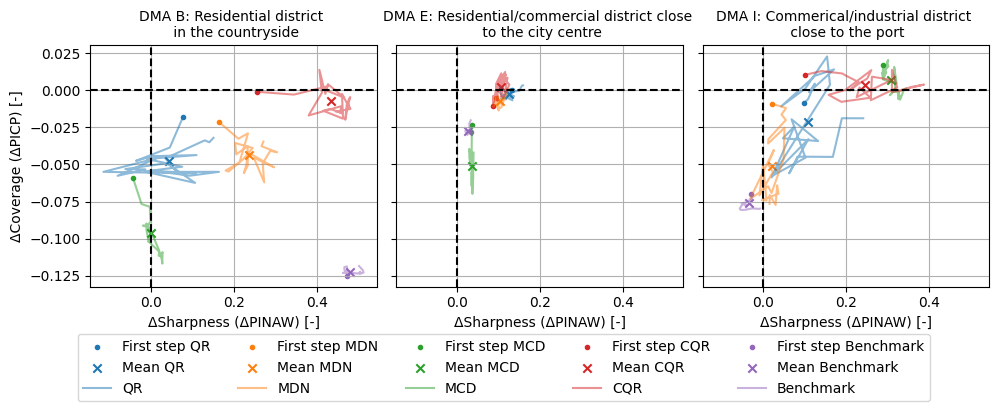

In [104]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3.5), sharex=True, sharey=True)

axs = ax.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# repeat every color in colors two times
colors = [color for color in colors for _ in (0, 1)]

# modelnames_prob = ['Mean QR', 'First step QR', 'QR', 'Mean MDN', 'First step MDN', 'MDN', 'Mean MCD', 'First step MCD', 'MCD', 'Mean CQR', 'First step CQR', 'CQR', 'Mean Benchmark', 'First step Benchmark', 'Benchmark']
modelnames_prob = ['First step QR', 'Mean QR', 'QR', 'First step MDN', 'Mean MDN', 'MDN', 'First step MCD', 'Mean MCD', 'MCD', 'First step CQR', 'Mean CQR', 'CQR', 'First step Benchmark', 'Mean Benchmark', 'Benchmark']
iis = [1,4,8]
for i, (dma, ax) in enumerate(zip(DMAs, axs)):
    # Plot each model for the current DMA with the corresponding color
    # for j, model in enumerate(modelnames_prob):
        # ax.scatter(df_test_robust_pinaw[dma][model], df_test_picp[dma][model], color=colors[j], label=model)

    # Set labels for rows and columns
    if i == 0:
        ax.set_ylabel('ΔCoverage (ΔPICP) [-]')
    else:
        ax.yaxis.set_tick_params(labelleft=False)

    if i >= 0:
        ax.set_xlabel('ΔSharpness (ΔPINAW) [-]')
    else:
        ax.xaxis.set_tick_params(labelbottom=False)

    i = iis[i]


    # Differences for QR and MDN using .iloc
    # QR Model Differences
    diff_robust_pinaw_qr = -mlp_val_qr_robust_pinaw_2d.iloc[:, i] + mlp_qr_robust_pinaw_2d.iloc[:, i]
    diff_picp_qr = -mlp_val_qr_picp_2d.iloc[:, i] + mlp_qr_picp_2d.iloc[:, i]

    # MDN Model Differences
    diff_robust_pinaw_mdn = -mlp_val_mdn_robust_pinaw_2d.iloc[:, i] + mlp_mdn_robust_pinaw_2d.iloc[:, i]
    diff_picp_mdn = -mlp_val_mdn_picp_2d.iloc[:, i] + mlp_mdn_picp_2d.iloc[:, i]

    # Other models using normal selection [i]
    # MCD Model Differences
    diff_robust_pinaw_mcd = -mlp_val_mcd_robust_pinaw_2d[i] + mlp_mcd_robust_pinaw_2d[i]
    diff_picp_mcd = -mlp_val_mcd_picp_2d[i] + mlp_mcd_picp_2d[i]

    # CQR Model Differences
    diff_robust_pinaw_cqr = -mlp_val_cp_robust_pinaw_2d[i] + mlp_cp_robust_pinaw_2d[i]
    diff_picp_cqr = -mlp_val_cp_picp_2d[i] + mlp_cp_picp_2d[i]

    # Benchmark Model Differences
    diff_robust_pinaw_bench = -naive_val_robust_pinaw_2d[i] + naive_robust_pinaw_2d[i]
    diff_picp_bench = -naive_val_picp_2d[i] + naive_picp_2d[i]

    # Plotting all data points, beginning, and mean for each model
    ax.scatter(diff_robust_pinaw_qr.iloc[0], diff_picp_qr.iloc[0], color=colors[0], marker='.')
    ax.scatter(diff_robust_pinaw_qr.mean(), diff_picp_qr.mean(), color=colors[0], marker='x')
    ax.plot(diff_robust_pinaw_qr, diff_picp_qr, color=colors[1], alpha=0.5, label='QR')

    ax.scatter(diff_robust_pinaw_mdn.iloc[0], diff_picp_mdn.iloc[0], color=colors[2], marker='.')
    ax.scatter(diff_robust_pinaw_mdn.mean(), diff_picp_mdn.mean(), color=colors[2], marker='x')
    ax.plot(diff_robust_pinaw_mdn, diff_picp_mdn, color=colors[3], alpha=0.5, label='MDN')

    ax.scatter(diff_robust_pinaw_mcd[0], diff_picp_mcd[0], color=colors[4], marker='.')
    ax.scatter(diff_robust_pinaw_mcd.mean(), diff_picp_mcd.mean(), color=colors[4], marker='x')
    ax.plot(diff_robust_pinaw_mcd, diff_picp_mcd, color=colors[5], alpha=0.5, label='MCD')

    ax.scatter(diff_robust_pinaw_cqr[0], diff_picp_cqr[0], color=colors[6], marker='.')
    ax.scatter(diff_robust_pinaw_cqr.mean(), diff_picp_cqr.mean(), color=colors[6], marker='x')
    ax.plot(diff_robust_pinaw_cqr, diff_picp_cqr, color=colors[7], alpha=0.5, label='CQR')

    ax.scatter(diff_robust_pinaw_bench[0], diff_picp_bench[0], color=colors[8], marker='.')
    ax.scatter(diff_robust_pinaw_bench.mean(), diff_picp_bench.mean(), color=colors[8], marker='x')
    ax.plot(diff_robust_pinaw_bench, diff_picp_bench, color=colors[9], alpha=0.5, label='Benchmark')

    ax.axhline(0, color='black', linestyle='--')
    ax.axvline(0, color='black', linestyle='--')
    # ax.set_ylim(-0.01, 0.05)
    ax.grid()
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)

# Legend and layout adjustments
legnd = fig.legend(modelnames_prob, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.18))
fig.tight_layout()
fig.savefig('../figures/delta_2d_metrics_picp_robust_pinaw_VALIDATION_COMPARE_small.png', dpi=300, bbox_extra_artists=[legnd], bbox_inches='tight')


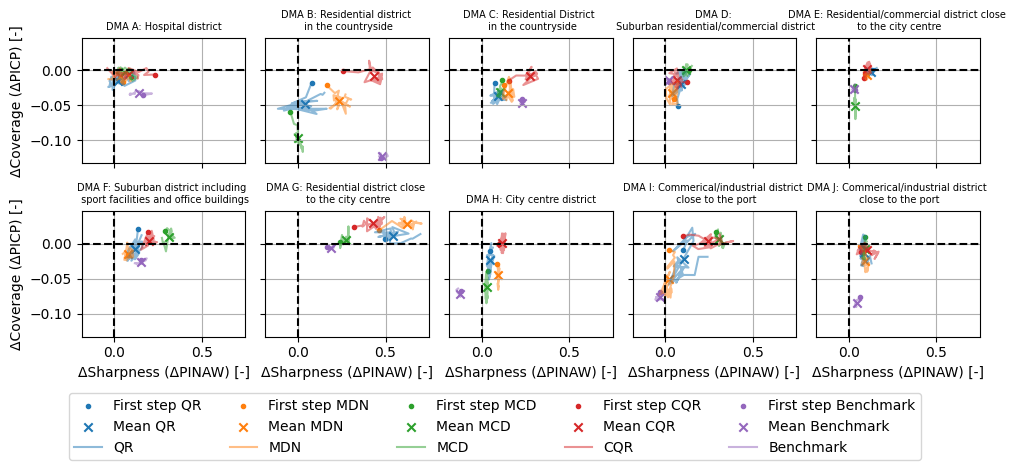

In [105]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True)

axs = ax.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# repeat every color in colors two times
colors = [color for color in colors for _ in (0, 1)]

# modelnames_prob = ['Mean QR', 'First step QR', 'QR', 'Mean MDN', 'First step MDN', 'MDN', 'Mean MCD', 'First step MCD', 'MCD', 'Mean CQR', 'First step CQR', 'CQR', 'Mean Benchmark', 'First step Benchmark', 'Benchmark']
modelnames_prob = ['First step QR', 'Mean QR', 'QR', 'First step MDN', 'Mean MDN', 'MDN', 'First step MCD', 'Mean MCD', 'MCD', 'First step CQR', 'Mean CQR', 'CQR', 'First step Benchmark', 'Mean Benchmark', 'Benchmark']
# iis = [1,5,8]
for i, (dma, ax) in enumerate(zip(DMAs, axs)):
    # Plot each model for the current DMA with the corresponding color
    # for j, model in enumerate(modelnames_prob):
        # ax.scatter(df_test_robust_pinaw[dma][model], df_test_picp[dma][model], color=colors[j], label=model)

    # Set labels for rows and columns
    if i == 0 or i ==5:
        ax.set_ylabel('ΔCoverage (ΔPICP) [-]')
    else:
        ax.yaxis.set_tick_params(labelleft=False)

    if i >= 5:
        ax.set_xlabel('ΔSharpness (ΔPINAW) [-]')
    else:
        ax.xaxis.set_tick_params(labelbottom=False)



    # Differences for QR and MDN using .iloc
    # QR Model Differences
    diff_robust_pinaw_qr = -mlp_val_qr_robust_pinaw_2d.iloc[:, i] + mlp_qr_robust_pinaw_2d.iloc[:, i]
    diff_picp_qr = -mlp_val_qr_picp_2d.iloc[:, i] + mlp_qr_picp_2d.iloc[:, i]

    # MDN Model Differences
    diff_robust_pinaw_mdn = -mlp_val_mdn_robust_pinaw_2d.iloc[:, i] + mlp_mdn_robust_pinaw_2d.iloc[:, i]
    diff_picp_mdn = -mlp_val_mdn_picp_2d.iloc[:, i] + mlp_mdn_picp_2d.iloc[:, i]

    # Other models using normal selection [i]
    # MCD Model Differences
    diff_robust_pinaw_mcd = -mlp_val_mcd_robust_pinaw_2d[i] + mlp_mcd_robust_pinaw_2d[i]
    diff_picp_mcd = -mlp_val_mcd_picp_2d[i] + mlp_mcd_picp_2d[i]

    # CQR Model Differences
    diff_robust_pinaw_cqr = -mlp_val_cp_robust_pinaw_2d[i] + mlp_cp_robust_pinaw_2d[i]
    diff_picp_cqr = -mlp_val_cp_picp_2d[i] + mlp_cp_picp_2d[i]

    # Benchmark Model Differences
    diff_robust_pinaw_bench = -naive_val_robust_pinaw_2d[i] + naive_robust_pinaw_2d[i]
    diff_picp_bench = -naive_val_picp_2d[i] + naive_picp_2d[i]

    # Plotting all data points, beginning, and mean for each model
    ax.scatter(diff_robust_pinaw_qr.iloc[0], diff_picp_qr.iloc[0], color=colors[0], marker='.')
    ax.scatter(diff_robust_pinaw_qr.mean(), diff_picp_qr.mean(), color=colors[0], marker='x')
    ax.plot(diff_robust_pinaw_qr, diff_picp_qr, color=colors[1], alpha=0.5, label='QR')

    ax.scatter(diff_robust_pinaw_mdn.iloc[0], diff_picp_mdn.iloc[0], color=colors[2], marker='.')
    ax.scatter(diff_robust_pinaw_mdn.mean(), diff_picp_mdn.mean(), color=colors[2], marker='x')
    ax.plot(diff_robust_pinaw_mdn, diff_picp_mdn, color=colors[3], alpha=0.5, label='MDN')

    ax.scatter(diff_robust_pinaw_mcd[0], diff_picp_mcd[0], color=colors[4], marker='.')
    ax.scatter(diff_robust_pinaw_mcd.mean(), diff_picp_mcd.mean(), color=colors[4], marker='x')
    ax.plot(diff_robust_pinaw_mcd, diff_picp_mcd, color=colors[5], alpha=0.5, label='MCD')

    ax.scatter(diff_robust_pinaw_cqr[0], diff_picp_cqr[0], color=colors[6], marker='.')
    ax.scatter(diff_robust_pinaw_cqr.mean(), diff_picp_cqr.mean(), color=colors[6], marker='x')
    ax.plot(diff_robust_pinaw_cqr, diff_picp_cqr, color=colors[7], alpha=0.5, label='CQR')

    ax.scatter(diff_robust_pinaw_bench[0], diff_picp_bench[0], color=colors[8], marker='.')
    ax.scatter(diff_robust_pinaw_bench.mean(), diff_picp_bench.mean(), color=colors[8], marker='x')
    ax.plot(diff_robust_pinaw_bench, diff_picp_bench, color=colors[9], alpha=0.5, label='Benchmark')

    ax.axhline(0, color='black', linestyle='--')
    ax.axvline(0, color='black', linestyle='--')
    # ax.set_ylim(-0.01, 0.05)
    ax.grid()
    ax.set_title(new_column_names_with_newlines[i], fontsize=7)

# Legend and layout adjustments
legnd = fig.legend(modelnames_prob, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.18))
fig.tight_layout()
# fig.savefig('../figures/delta_2d_metrics_picp_robust_pinaw_VALIDATION_COMPARE.png', dpi=300, bbox_extra_artists=[legnd], bbox_inches='tight')


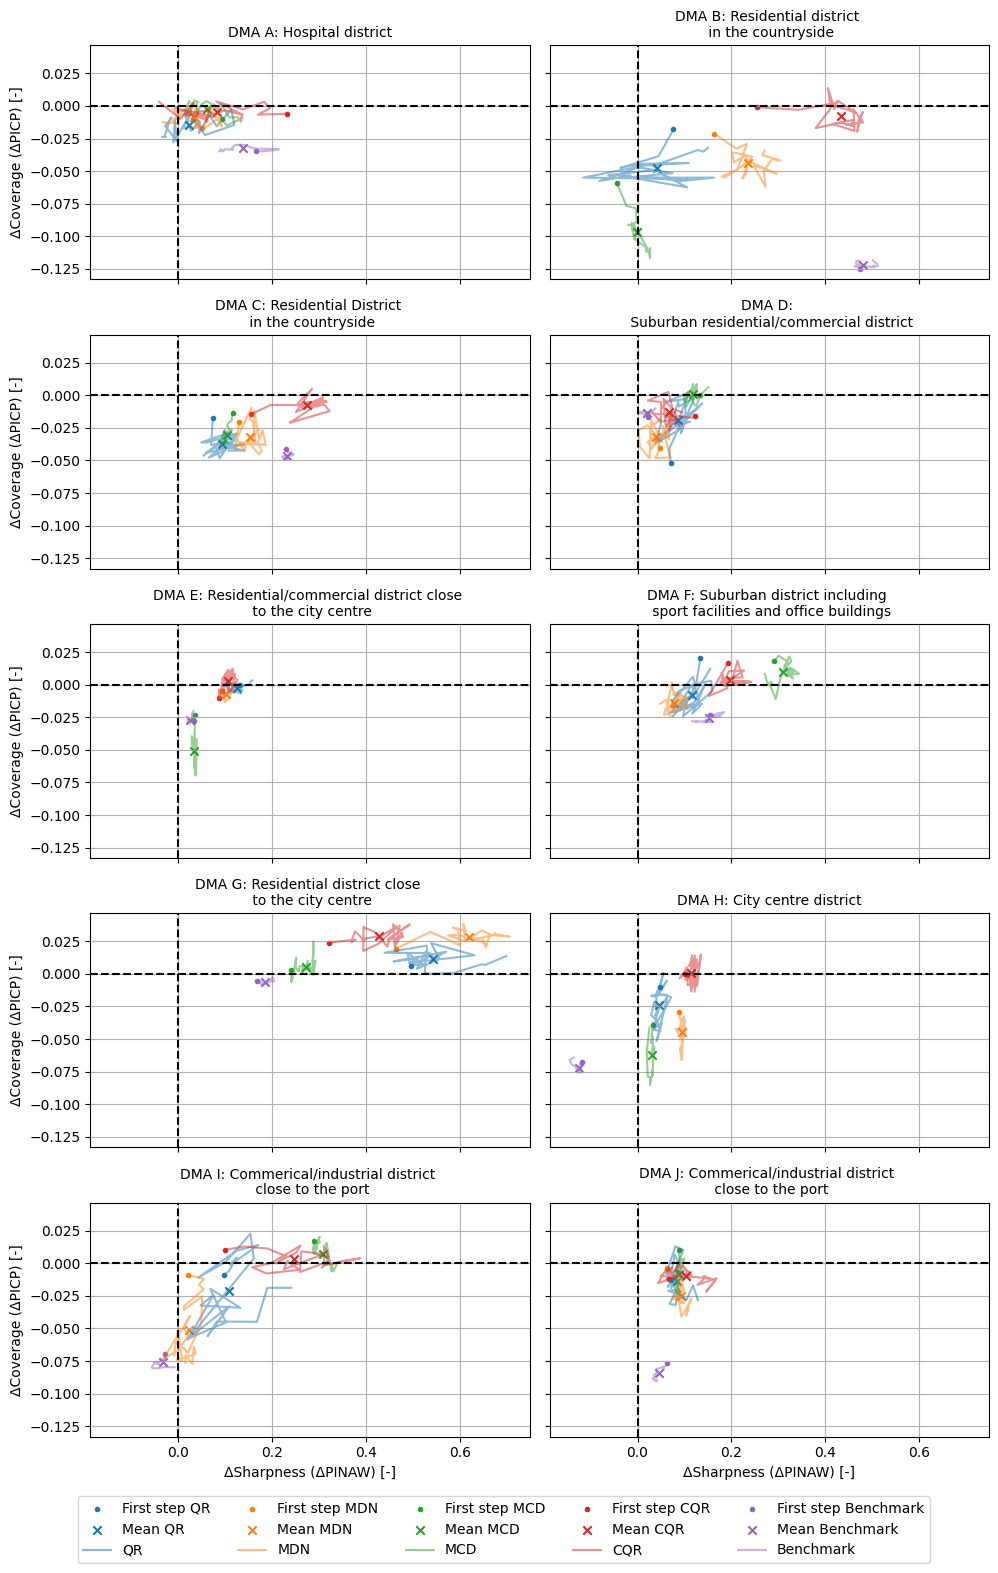

In [150]:
fig, ax = plt.subplots(5, 2, figsize=(10, 15), sharex=True, sharey=True)

axs = ax.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# repeat every color in colors two times
colors = [color for color in colors for _ in (0, 1)]

# modelnames_prob = ['Mean QR', 'First step QR', 'QR', 'Mean MDN', 'First step MDN', 'MDN', 'Mean MCD', 'First step MCD', 'MCD', 'Mean CQR', 'First step CQR', 'CQR', 'Mean Benchmark', 'First step Benchmark', 'Benchmark']
modelnames_prob = ['First step QR', 'Mean QR', 'QR', 'First step MDN', 'Mean MDN', 'MDN', 'First step MCD', 'Mean MCD', 'MCD', 'First step CQR', 'Mean CQR', 'CQR', 'First step Benchmark', 'Mean Benchmark', 'Benchmark']
# iis = [1,5,8]
for i, (dma, ax) in enumerate(zip(DMAs, axs)):

    # Set labels for rows and columns
    if not (i%2):
        ax.set_ylabel('ΔCoverage (ΔPICP) [-]')
    else:
        ax.yaxis.set_tick_params(labelleft=False)

    if i >= 8:
        ax.set_xlabel('ΔSharpness (ΔPINAW) [-]')
    else:
        ax.xaxis.set_tick_params(labelbottom=False)

    # Differences for QR and MDN using .iloc
    # QR Model Differences
    diff_robust_pinaw_qr = -mlp_val_qr_robust_pinaw_2d.iloc[:, i] + mlp_qr_robust_pinaw_2d.iloc[:, i]
    diff_picp_qr = -mlp_val_qr_picp_2d.iloc[:, i] + mlp_qr_picp_2d.iloc[:, i]

    # MDN Model Differences
    diff_robust_pinaw_mdn = -mlp_val_mdn_robust_pinaw_2d.iloc[:, i] + mlp_mdn_robust_pinaw_2d.iloc[:, i]
    diff_picp_mdn = -mlp_val_mdn_picp_2d.iloc[:, i] + mlp_mdn_picp_2d.iloc[:, i]

    # Other models using normal selection [i]
    # MCD Model Differences
    diff_robust_pinaw_mcd = -mlp_val_mcd_robust_pinaw_2d[i] + mlp_mcd_robust_pinaw_2d[i]
    diff_picp_mcd = -mlp_val_mcd_picp_2d[i] + mlp_mcd_picp_2d[i]

    # CQR Model Differences
    diff_robust_pinaw_cqr = -mlp_val_cp_robust_pinaw_2d[i] + mlp_cp_robust_pinaw_2d[i]
    diff_picp_cqr = -mlp_val_cp_picp_2d[i] + mlp_cp_picp_2d[i]

    # Benchmark Model Differences
    diff_robust_pinaw_bench = -naive_val_robust_pinaw_2d[i] + naive_robust_pinaw_2d[i]
    diff_picp_bench = -naive_val_picp_2d[i] + naive_picp_2d[i]

    # Plotting all data points, beginning, and mean for each model
    ax.scatter(diff_robust_pinaw_qr.iloc[0], diff_picp_qr.iloc[0], color=colors[0], marker='.')
    ax.scatter(diff_robust_pinaw_qr.mean(), diff_picp_qr.mean(), color=colors[0], marker='x')
    ax.plot(diff_robust_pinaw_qr, diff_picp_qr, color=colors[1], alpha=0.5, label='QR')

    ax.scatter(diff_robust_pinaw_mdn.iloc[0], diff_picp_mdn.iloc[0], color=colors[2], marker='.')
    ax.scatter(diff_robust_pinaw_mdn.mean(), diff_picp_mdn.mean(), color=colors[2], marker='x')
    ax.plot(diff_robust_pinaw_mdn, diff_picp_mdn, color=colors[3], alpha=0.5, label='MDN')

    ax.scatter(diff_robust_pinaw_mcd[0], diff_picp_mcd[0], color=colors[4], marker='.')
    ax.scatter(diff_robust_pinaw_mcd.mean(), diff_picp_mcd.mean(), color=colors[4], marker='x')
    ax.plot(diff_robust_pinaw_mcd, diff_picp_mcd, color=colors[5], alpha=0.5, label='MCD')

    ax.scatter(diff_robust_pinaw_cqr[0], diff_picp_cqr[0], color=colors[6], marker='.')
    ax.scatter(diff_robust_pinaw_cqr.mean(), diff_picp_cqr.mean(), color=colors[6], marker='x')
    ax.plot(diff_robust_pinaw_cqr, diff_picp_cqr, color=colors[7], alpha=0.5, label='CQR')

    ax.scatter(diff_robust_pinaw_bench[0], diff_picp_bench[0], color=colors[8], marker='.')
    ax.scatter(diff_robust_pinaw_bench.mean(), diff_picp_bench.mean(), color=colors[8], marker='x')
    ax.plot(diff_robust_pinaw_bench, diff_picp_bench, color=colors[9], alpha=0.5, label='Benchmark')

    ax.axhline(0, color='black', linestyle='--')
    ax.axvline(0, color='black', linestyle='--')
    # ax.set_ylim(-0.01, 0.05)
    ax.grid()
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)

# Legend and layout adjustments
legnd = fig.legend(modelnames_prob, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05))
fig.tight_layout()
fig.savefig('../figures/delta_2d_metrics_picp_robust_pinaw_VALIDATION_COMPARE.png', dpi=300, bbox_extra_artists=[legnd], bbox_inches='tight')


In [106]:
change_picp_qr = (mlp_val_qr_picp_2d-mlp_qr_picp_2d).abs().mean(axis=1)
change_picp_mdn =(mlp_val_mdn_picp_2d-mlp_mdn_picp_2d).abs().mean(axis=1)
change_picp_mcd = torch.stack([torch.abs(mlp_val_mcd_picp_2d[i] - mlp_mcd_picp_2d[i]) for i in range(10)]).mean(axis=0)
change_picp_cqr = torch.stack([torch.abs(mlp_val_cp_picp_2d[i] - mlp_cp_picp_2d[i]) for i in range(10)]).mean(axis=0)
change_picp_naive = torch.stack([torch.abs(naive_val_picp_2d[i] - naive_picp_2d[i]) for i in range(10)]).mean(axis=0)



In [107]:
# Calculating changes in PICP for each model
change_picp_qr = (mlp_val_qr_picp_2d - mlp_qr_picp_2d).abs().mean(axis=1)
change_picp_mdn = (mlp_val_mdn_picp_2d - mlp_mdn_picp_2d).abs().mean(axis=1)
change_picp_mcd = torch.stack([torch.abs(mlp_val_mcd_picp_2d[i] - mlp_mcd_picp_2d[i]) for i in range(10)]).mean(axis=0)
change_picp_cqr = torch.stack([torch.abs(mlp_val_cp_picp_2d[i] - mlp_cp_picp_2d[i]) for i in range(10)]).mean(axis=0)
change_picp_naive = torch.stack([torch.abs(naive_val_picp_2d[i] - naive_picp_2d[i]) for i in range(10)]).mean(axis=0)

# Calculating changes in robust PINAW for each model
change_robust_pinaw_qr = (mlp_val_qr_robust_pinaw_2d - mlp_qr_robust_pinaw_2d).abs().mean(axis=1)
change_robust_pinaw_mdn = (mlp_val_mdn_robust_pinaw_2d - mlp_mdn_robust_pinaw_2d).abs().mean(axis=1)
change_robust_pinaw_mcd = torch.stack([torch.abs(mlp_val_mcd_robust_pinaw_2d[i] - mlp_mcd_robust_pinaw_2d[i]) for i in range(10)]).mean(axis=0)
change_robust_pinaw_cqr = torch.stack([torch.abs(mlp_val_cp_robust_pinaw_2d[i] - mlp_cp_robust_pinaw_2d[i]) for i in range(10)]).mean(axis=0)
change_robust_pinaw_naive = torch.stack([torch.abs(naive_val_robust_pinaw_2d[i] - naive_robust_pinaw_2d[i]) for i in range(10)]).mean(axis=0)

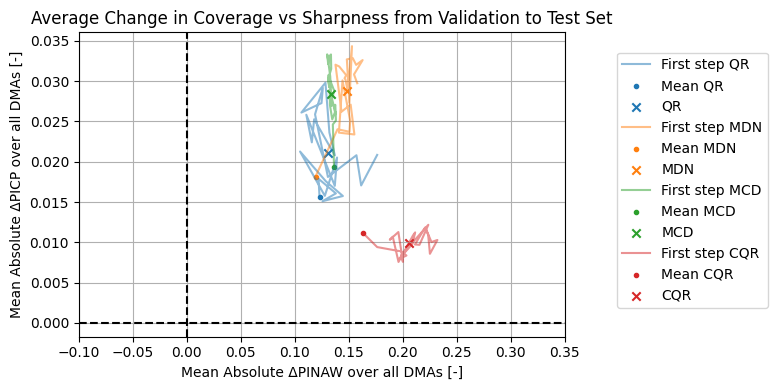

In [108]:
import torch
import matplotlib.pyplot as plt

# Calculating changes in PICP for each model
change_picp_qr = (mlp_val_qr_picp_2d - mlp_qr_picp_2d).abs().mean(axis=1)
change_picp_mdn = (mlp_val_mdn_picp_2d - mlp_mdn_picp_2d).abs().mean(axis=1)
change_picp_mcd = torch.stack([torch.abs(mlp_val_mcd_picp_2d[i] - mlp_mcd_picp_2d[i]) for i in range(10)]).mean(axis=0)
change_picp_cqr = torch.stack([torch.abs(mlp_val_cp_picp_2d[i] - mlp_cp_picp_2d[i]) for i in range(10)]).mean(axis=0)
change_picp_naive = torch.stack([torch.abs(naive_val_picp_2d[i] - naive_picp_2d[i]) for i in range(10)]).mean(axis=0)

# Calculating changes in robust PINAW for each model
change_robust_pinaw_qr = (mlp_val_qr_robust_pinaw_2d - mlp_qr_robust_pinaw_2d).abs().mean(axis=1)
change_robust_pinaw_mdn = (mlp_val_mdn_robust_pinaw_2d - mlp_mdn_robust_pinaw_2d).abs().mean(axis=1)
change_robust_pinaw_mcd = torch.stack([torch.abs(mlp_val_mcd_robust_pinaw_2d[i] - mlp_mcd_robust_pinaw_2d[i]) for i in range(10)]).mean(axis=0)
change_robust_pinaw_cqr = torch.stack([torch.abs(mlp_val_cp_robust_pinaw_2d[i] - mlp_cp_robust_pinaw_2d[i]) for i in range(10)]).mean(axis=0)
change_robust_pinaw_naive = torch.stack([torch.abs(naive_val_robust_pinaw_2d[i] - naive_robust_pinaw_2d[i]) for i in range(10)]).mean(axis=0)

# Plotting the results
fig, ax = plt.subplots(figsize=(6, 4))

# Colors for the models
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Plotting the line plots and individual points for each model

# QR Model
ax.plot(change_robust_pinaw_qr, change_picp_qr, color=colors[0], alpha=0.5, label='QR')
ax.scatter(change_robust_pinaw_qr.iloc[0], change_picp_qr.iloc[0], color=colors[0], marker='.')
ax.scatter(change_robust_pinaw_qr.mean(), change_picp_qr.mean(), color=colors[0], marker='x')

# MDN Model
ax.plot(change_robust_pinaw_mdn, change_picp_mdn, color=colors[1], alpha=0.5, label='MDN')
ax.scatter(change_robust_pinaw_mdn.iloc[0], change_picp_mdn.iloc[0], color=colors[1], marker='.')
ax.scatter(change_robust_pinaw_mdn.mean(), change_picp_mdn.mean(), color=colors[1], marker='x')

# MCD Model
ax.plot(change_robust_pinaw_mcd, change_picp_mcd, color=colors[2], alpha=0.5, label='MCD')
ax.scatter(change_robust_pinaw_mcd[0], change_picp_mcd[0], color=colors[2], marker='.')
ax.scatter(change_robust_pinaw_mcd.mean().item(), change_picp_mcd.mean().item(), color=colors[2], marker='x')

# CQR Model
ax.plot(change_robust_pinaw_cqr, change_picp_cqr, color=colors[3], alpha=0.5, label='CQR')
ax.scatter(change_robust_pinaw_cqr[0], change_picp_cqr[0], color=colors[3], marker='.')
ax.scatter(change_robust_pinaw_cqr.mean().item(), change_picp_cqr.mean().item(), color=colors[3], marker='x')

# # Naive Model
# ax.plot(change_robust_pinaw_naive, change_picp_naive, color=colors[4], alpha=0.5, label='Naive')
# ax.scatter(change_robust_pinaw_naive[0], change_picp_naive[0], color=colors[4], marker='.')
# ax.scatter(change_robust_pinaw_naive.mean().item(), change_picp_naive.mean().item(), color=colors[4], marker='x')

# Labels and grid
ax.set_xlabel('Mean Absolute ΔPINAW over all DMAs [-]')
ax.set_ylabel('Mean Absolute ΔPICP over all DMAs [-]')
ax.axhline(0, color='black', linestyle='--')
ax.axvline(0, color='black', linestyle='--')
ax.grid()
ax.set_xlim(-0.1,0.35)

# Title and legend
ax.set_title('Average Change in Coverage vs Sharpness from Validation to Test Set')
legnd = fig.legend(modelnames_prob[:-3], loc='lower right', ncol=1, bbox_to_anchor=(1.3, 0.2))

# Show plot
plt.tight_layout()
plt.show()
fig.savefig('../figures/delta_metrics_avg_abs_picp_robust_pinaw.png', dpi=300, bbox_extra_artists=[legnd], bbox_inches='tight')


In [109]:
modelnames_prob

['First step QR',
 'Mean QR',
 'QR',
 'First step MDN',
 'Mean MDN',
 'MDN',
 'First step MCD',
 'Mean MCD',
 'MCD',
 'First step CQR',
 'Mean CQR',
 'CQR',
 'First step Benchmark',
 'Mean Benchmark',
 'Benchmark']

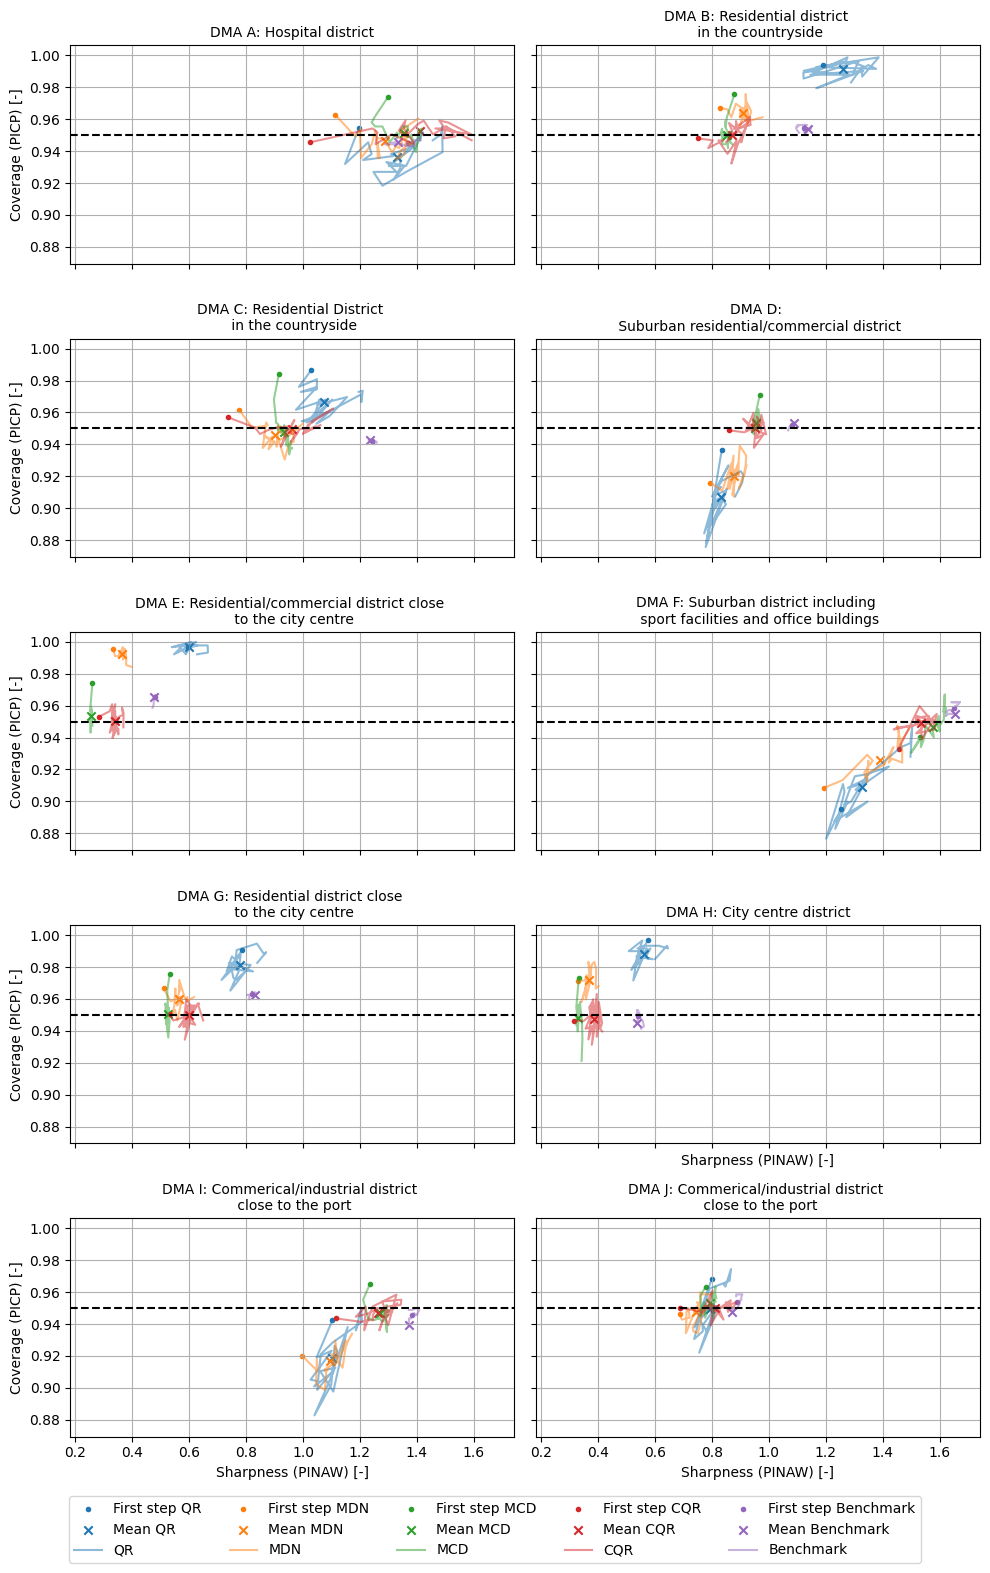

In [149]:
fig, ax = plt.subplots(5, 2, figsize=(10, 15), sharex=True, sharey=True)
axs = ax.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# repeat every color in colors two times
colors = [color for color in colors for _ in (0, 1)]

# modelnames_prob = ['Mean QR', 'First step QR', 'QR', 'Mean MDN', 'First step MDN', 'MDN', 'Mean MCD', 'First step MCD', 'MCD', 'Mean CQR', 'First step CQR', 'CQR', 'Mean Benchmark', 'First step Benchmark', 'Benchmark']
modelnames_prob = ['First step QR', 'Mean QR', 'QR', 'First step MDN', 'Mean MDN', 'MDN', 'First step MCD', 'Mean MCD', 'MCD', 'First step CQR', 'Mean CQR', 'CQR', 'First step Benchmark', 'Mean Benchmark', 'Benchmark']

for i, (dma, ax) in enumerate(zip(DMAs, axs)):
    # Plot each model for the current DMA with the corresponding color


    # now plot the validation sets in here, similarly as done above , theyre named mlp_val_..., use the same colors
    ax.scatter(mlp_val_qr_robust_pinaw_2d.iloc[0,i], mlp_val_qr_picp_2d.iloc[0,i], color=colors[0], label='First step QR ', marker='.')
    ax.scatter(mlp_val_qr_robust_pinaw_2d.iloc[:,i].mean(), mlp_val_qr_picp_2d.iloc[:,i].mean(), color=colors[0], label='Mean QR', marker='x')
    ax.plot(mlp_val_qr_robust_pinaw_2d.iloc[:,i], mlp_val_qr_picp_2d.iloc[:,i], color=colors[1], label='QR', alpha=0.5)

    ax.scatter(mlp_val_mdn_robust_pinaw_2d.iloc[0,i], mlp_val_mdn_picp_2d.iloc[0,i], color=colors[2], label='First step MDN', marker='.')
    ax.scatter(mlp_val_mdn_robust_pinaw_2d.iloc[:,i].mean(), mlp_val_mdn_picp_2d.iloc[:,i].mean(), color=colors[2], label='Mean MDN', marker='x')
    ax.plot(mlp_val_mdn_robust_pinaw_2d.iloc[:,i], mlp_val_mdn_picp_2d.iloc[:,i], color=colors[3], label='MDN', alpha=0.5)

    ax.scatter(mlp_val_mcd_robust_pinaw_2d[i][0], mlp_val_mcd_picp_2d[i][0], color=colors[4], label='First step MCD', marker='.')
    ax.scatter(mlp_val_mcd_robust_pinaw_2d[i].mean(), mlp_val_mcd_picp_2d[i].mean(), color=colors[4], label='Mean MCD', marker='x')
    ax.plot(mlp_val_mcd_robust_pinaw_2d[i], mlp_val_mcd_picp_2d[i], color=colors[5], label='MCD', alpha=0.5)

    ax.scatter(mlp_val_cp_robust_pinaw_2d[i][0], mlp_val_cp_picp_2d[i][0], color=colors[6], label='First step CQR', marker='.')
    ax.scatter(mlp_val_cp_robust_pinaw_2d[i].mean(), mlp_val_cp_picp_2d[i].mean(), color=colors[6], label='Men CQR', marker='x')
    ax.plot(mlp_val_cp_robust_pinaw_2d[i], mlp_val_cp_picp_2d[i], color=colors[7], label='CQR', alpha=0.5)

    ax.scatter(naive_val_robust_pinaw_2d[i].mean(), naive_val_picp_2d[i].mean(), color=colors[8], label='First step Benchmark', marker='.')
    ax.scatter(naive_val_robust_pinaw_2d[i][0], naive_val_picp_2d[i][0], color=colors[8], label='Mean Benchmark', marker='x')
    ax.plot(naive_val_robust_pinaw_2d[i], naive_val_picp_2d[i], color=colors[9], label='Benchmark', alpha=0.5)



    # Set labels for rows and columns
    if not (i%2):
        ax.set_ylabel('Coverage (PICP) [-]')
    else:
        ax.yaxis.set_tick_params(labelleft=False)

    if i >= 8:
        ax.set_xlabel('Sharpness (PINAW) [-]')
    else:
        ax.xaxis.set_tick_params(labelbottom=False)

    ax.axhline(0.95, color='black', linestyle='--')
    ax.grid()
    # ax.set_ylim(df_test_picp.min().min()*0.99, df_test_picp.max().max()*1.01)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)

# Create a legend with the model names and colors
lgd = fig.legend(modelnames_prob, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05))

fig.tight_layout()
fig.savefig('../figures/2d_metrics_picp_robust_pinaw_VAL.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


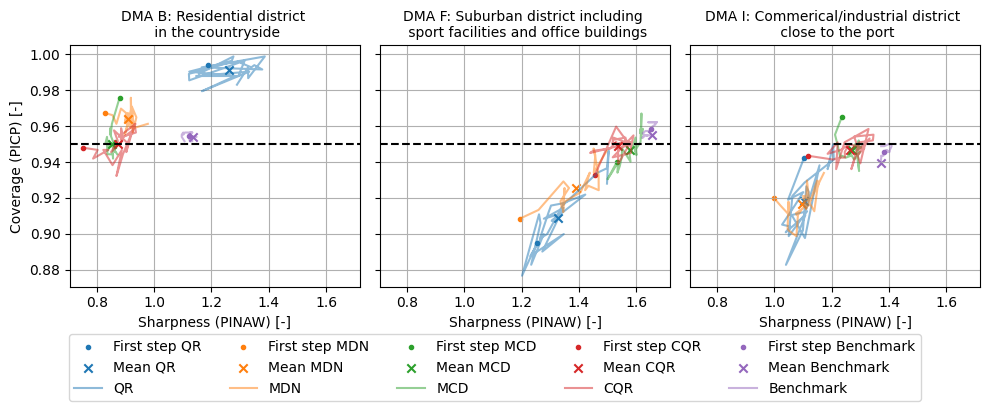

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3.5), sharex=True, sharey=True)
axs = ax.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# repeat every color in colors two times
colors = [color for color in colors for _ in (0, 1)]

# modelnames_prob = ['Mean QR', 'First step QR', 'QR', 'Mean MDN', 'First step MDN', 'MDN', 'Mean MCD', 'First step MCD', 'MCD', 'Mean CQR', 'First step CQR', 'CQR', 'Mean Benchmark', 'First step Benchmark', 'Benchmark']
modelnames_prob = ['First step QR', 'Mean QR', 'QR', 'First step MDN', 'Mean MDN', 'MDN', 'First step MCD', 'Mean MCD', 'MCD', 'First step CQR', 'Mean CQR', 'CQR', 'First step Benchmark', 'Mean Benchmark', 'Benchmark']
iis = [1,5,8]
for i, (dma, ax) in enumerate(zip(DMAs, axs)):
    # Plot each model for the current DMA with the corresponding color

    # Set labels for rows and columns
    if i == 0 or i == 5:
        ax.set_ylabel('Coverage (PICP) [-]')



    ax.set_xlabel('Sharpness (PINAW) [-]')


    i = iis[i]

    # now plot the validation sets in here, similarly as done above , theyre named mlp_val_..., use the same colors
    ax.scatter(mlp_val_qr_robust_pinaw_2d.iloc[0,i], mlp_val_qr_picp_2d.iloc[0,i], color=colors[0], label='First step QR ', marker='.')
    ax.scatter(mlp_val_qr_robust_pinaw_2d.iloc[:,i].mean(), mlp_val_qr_picp_2d.iloc[:,i].mean(), color=colors[0], label='Mean QR', marker='x')
    ax.plot(mlp_val_qr_robust_pinaw_2d.iloc[:,i], mlp_val_qr_picp_2d.iloc[:,i], color=colors[1], label='QR', alpha=0.5)

    ax.scatter(mlp_val_mdn_robust_pinaw_2d.iloc[0,i], mlp_val_mdn_picp_2d.iloc[0,i], color=colors[2], label='First step MDN', marker='.')
    ax.scatter(mlp_val_mdn_robust_pinaw_2d.iloc[:,i].mean(), mlp_val_mdn_picp_2d.iloc[:,i].mean(), color=colors[2], label='Mean MDN', marker='x')
    ax.plot(mlp_val_mdn_robust_pinaw_2d.iloc[:,i], mlp_val_mdn_picp_2d.iloc[:,i], color=colors[3], label='MDN', alpha=0.5)

    ax.scatter(mlp_val_mcd_robust_pinaw_2d[i][0], mlp_val_mcd_picp_2d[i][0], color=colors[4], label='First step MCD', marker='.')
    ax.scatter(mlp_val_mcd_robust_pinaw_2d[i].mean(), mlp_val_mcd_picp_2d[i].mean(), color=colors[4], label='Mean MCD', marker='x')
    ax.plot(mlp_val_mcd_robust_pinaw_2d[i], mlp_val_mcd_picp_2d[i], color=colors[5], label='MCD', alpha=0.5)

    ax.scatter(mlp_val_cp_robust_pinaw_2d[i][0], mlp_val_cp_picp_2d[i][0], color=colors[6], label='First step CQR', marker='.')
    ax.scatter(mlp_val_cp_robust_pinaw_2d[i].mean(), mlp_val_cp_picp_2d[i].mean(), color=colors[6], label='Men CQR', marker='x')
    ax.plot(mlp_val_cp_robust_pinaw_2d[i], mlp_val_cp_picp_2d[i], color=colors[7], label='CQR', alpha=0.5)

    ax.scatter(naive_val_robust_pinaw_2d[i].mean(), naive_val_picp_2d[i].mean(), color=colors[8], label='First step Benchmark', marker='.')
    ax.scatter(naive_val_robust_pinaw_2d[i][0], naive_val_picp_2d[i][0], color=colors[8], label='Mean Benchmark', marker='x')
    ax.plot(naive_val_robust_pinaw_2d[i], naive_val_picp_2d[i], color=colors[9], label='Benchmark', alpha=0.5)



    ax.axhline(0.95, color='black', linestyle='--')
    ax.grid()
    # ax.set_ylim(df_test_picp.min().min()*0.99, df_test_picp.max().max()*1.01)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)

# Create a legend with the model names and colors
lgd = fig.legend(modelnames_prob, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.18))

fig.tight_layout()
fig.savefig('../figures/2d_metrics_picp_robust_pinaw_VAL_SMALL.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


In [126]:


allowed_picp_drops = [0.01, 0.02, 0.03, 0.04, 0.05]
df_winkler_picp_rel_val = []

for i, allowed_picp_drop in enumerate(allowed_picp_drops):
    # print(f'allowed picp drop relative to validation picp: {allowed_picp_drop}')

    df_winkler_picp_i = df_test_winkler_norm.loc[:,DMAs][df_test_picp>(df_val_picp-allowed_picp_drop)]
    min_per_column = df_winkler_picp_i.min(axis=0)
    count_min_per_row = df_winkler_picp_i.eq(min_per_column, axis=1).sum(axis=1)
    df_winkler_picp_rel_val.append(count_min_per_row)
    df_winkler_picp_style = df_winkler_picp_i.round(2).style.apply(color_min_max_subset, axis=0).format("{:.2f}")
    print()
    # print(df_winkler_picp_style.to_latex())
    print(format_styled_latex_table_with_booktabs(df_winkler_picp_style, f'Conditional Relative Winkler Score on test set by accepting a coverage drop to ${np.round(0.95-allowed_picp_drop,2)}$'))
    # display(df_winkler_picp_style)



\begin{table}[H]
\caption{Conditional Relative Winkler Score on test set by accepting a coverage drop to $0.94$}
\label{table: Conditional Relative Winkler Score on test set by accepting a coverage drop to $0.94$}
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & A & B & C & D & E & F & G & H & I & J \\
\midrule
QR & - & - & - & - & \cellcolor{lightred} \textbf{1.18} & \cellcolor{lightgreen} \textbf{0.90} & \cellcolor{lightred} \textbf{1.21} & - & - & - \\
MDN & \cellcolor{lightgreen} \textbf{0.85} & - & - & - & \cellcolor{lightgreen} \textbf{0.79} & - & 1.09 & - & - & - \\
MCD & \cellcolor{lightred} \textbf{1.09} & - & - & \cellcolor{lightgreen} \textbf{0.92} & - & \cellcolor{lightred} \textbf{0.98} & \cellcolor{lightgreen} \textbf{0.81} & - & \cellcolor{lightred} \textbf{0.84} & \cellcolor{lightgreen} \textbf{0.76} \\
CQR & 1.07 & \cellcolor{lightgreen} \textbf{0.60} & \cellcolor{lightgreen} \textbf{0.72} & - & 0.81 & 0.92 & 0.97 & \cellcolor{lightgreen

In [131]:
allowed_picp_drops = [0.01, 0.02, 0.03, 0.04, 0.05]
desired_picp = 0.95
df_winkler_picp_095 = []
for i, allowed_picp_drop in enumerate(allowed_picp_drops):
    # print(f'allowed picp drop: {allowed_picp_drop}')
    df_winkler_picp_i = df_test_winkler_norm.loc[:,DMAs][df_test_picp>(desired_picp-allowed_picp_drop)]
    min_per_column = df_winkler_picp_i.min(axis=0)
    count_min_per_row = df_winkler_picp_i.eq(min_per_column, axis=1).sum(axis=1)
    # print(count_min_per_row)
    df_winkler_picp_095.append(count_min_per_row)
    df_winkler_picp_style = df_winkler_picp_i.round(2).style.apply(color_min_max_subset, axis=0).format("{:.2f}")
    print(format_styled_latex_table_with_booktabs(df_winkler_picp_style, f'Conditional Relative Winkler Score on test set by accepting a coverage drop of ${np.round(allowed_picp_drop,2)}$ relative to the coverage of the validation set'))
    # print(df_winkler_picp_style.to_latex())
    # display(df_winkler_picp_style)

\begin{table}[H]
\caption{Conditional Relative Winkler Score on test set by accepting a coverage drop of $0.01$ relative to the coverage of the validation set}
\label{table: Conditional Relative Winkler Score on test set by accepting a coverage drop of $0.01$ relative to the coverage of the validation set}
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & A & B & C & D & E & F & G & H & I & J \\
\midrule
QR & - & \cellcolor{lightred} \textbf{0.61} & - & - & \cellcolor{lightred} \textbf{1.18} & - & \cellcolor{lightred} \textbf{1.21} & \cellcolor{lightred} \textbf{1.05} & - & - \\
MDN & - & - & - & - & \cellcolor{lightgreen} \textbf{0.79} & - & 1.09 & - & - & - \\
MCD & \cellcolor{lightred} \textbf{1.09} & - & - & \cellcolor{lightgreen} \textbf{0.92} & - & \cellcolor{lightred} \textbf{0.98} & \cellcolor{lightgreen} \textbf{0.81} & - & \cellcolor{lightred} \textbf{0.84} & \cellcolor{lightgreen} \textbf{0.76} \\
CQR & \cellcolor{lightgreen} \textbf{1.07} & \ce

In [ ]:
df_winkler_decline = pd.concat(df_winkler_picp_rel_val, axis=1)
df_winkler_decline.columns = [f'η={allowed_picp_drop:.2f}' for allowed_picp_drop in allowed_picp_drops]
df_winkler_decline.index = df_test_winkler.index
df_winkler_decline_095 = pd.concat(df_winkler_picp_095, axis=1)
df_winkler_decline_095.columns = [f'η={allowed_picp_drop:.2f}' for allowed_picp_drop in allowed_picp_drops]
df_winkler_decline_095.index = df_test_winkler.index
df_winkler_decline_095
df_combined = pd.concat({'Coverage decline relative to 0.95':df_winkler_decline_095, 'Coverage decline relative to validation set': df_winkler_decline}, axis=1)
css = [
    # dict(selector="th", props=[("border-style", "solid"), ("border-width", "1px")]),
    dict(selector=".col5", props=[("border-left", "2px solid black")]), 
]
df_combined_style = df_combined.style.set_table_styles(css).apply(show_largest_green, axis=0)
df_combined_style

In [ ]:
df_test_picp_style

In [ ]:
df_combined_style.to_latex()

'\\begin{table}\n\\.col52px solid black\n\\begin{tabular}{lrrrrrrrrrr}\n & \\multicolumn{5}{r}{Coverage decline relative to 0.95} & \\multicolumn{5}{r}{Coverage decline relative to validation set} \\\\\n & η=0.01 & η=0.02 & η=0.03 & η=0.04 & η=0.05 & η=0.01 & η=0.02 & η=0.03 & η=0.04 & η=0.05 \\\\\nQR-MLP & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\\\\nMDN-MLP & 1 & 2 & \\background-color#d9ecd9 \\font-weightbold 5 & \\background-color#d9ecd9 \\font-weightbold 7 & \\background-color#d9ecd9 \\font-weightbold 6 & 2 & 3 & 4 & \\background-color#d9ecd9 \\font-weightbold 5 & \\background-color#d9ecd9 \\font-weightbold 7 \\\\\nMCD-MLP & 3 & 2 & 1 & 1 & 2 & 3 & 2 & 1 & 1 & 1 \\\\\nCQR-MLP & \\background-color#d9ecd9 \\font-weightbold 6 & \\background-color#d9ecd9 \\font-weightbold 6 & 4 & 2 & 2 & \\background-color#d9ecd9 \\font-weightbold 4 & \\background-color#d9ecd9 \\font-weightbold 5 & \\background-color#d9ecd9 \\font-weightbold 5 & 4 & 2 \\\\\nBenchmark Model & 0 & 0 & 0 & 0 & 0 & 0 & 0 &

Text(0.5, 1.0, 'Water Demand Forecast')

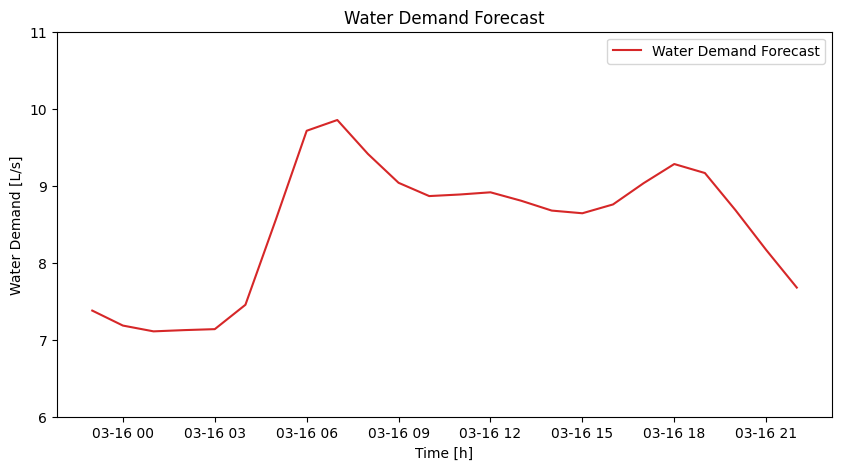

In [ ]:
# plot for the presentation

mcd_pt_test = torch.load('../show_results/results/TESTING_MLP_MCD_VAL2/results.pt')

q_pred_mcd_test_B = mlp_cp['B']['test']['preds']
y_test_B = mlp_cp['B']['test']['true']
scale1B, scale2B = mcd_pt_test['TESTING_MLP_MCD_VAL2_B_test']['series']['scale1'], mcd_pt_test['TESTING_MLP_MCD_VAL2_B_test']['series']['scale2']
test_data_dma_ind = torch.load(f'../data/sequences/24h_out_all_no_weather/test_ind_24h_out_all_no_weather_B.pt', map_location='cpu')
q_pred = q_pred_mcd_test_B*torch.tensor(scale1B)+torch.tensor(scale2B)
y_test_B = y_test_B*torch.tensor(scale1B)+torch.tensor(scale2B)
q_pred_mcd_test_B = q_pred_mcd_test_B*torch.tensor(scale1B)+torch.tensor(scale2B)
i =71# np.random.randint(0, q_pred_mcd_test_B.shape[0])

fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.fill_between(test_data_dma_ind[i], q_pred_mcd_test_B[i,:,0], q_pred_mcd_test_B[i,:,2], color='grey', alpha=0.5, label='95% Prediction Interval')

# ax.plot(test_data_dma_ind[i], y_test_B[i], label='True Water Demand', color='tab:blue')

ax.plot(test_data_dma_ind[i], q_pred_mcd_test_B[i,:,1], label='Water Demand Forecast', color='tab:red')
# make grey fill within the interval
ax.set_ylim(6,11)
ax.set_xlabel('Time [h]')
ax.set_ylabel('Water Demand [L/s]')
ax.legend()
ax.set_title('Water Demand Forecast')

# visualize probabilistic forecasts stepwise

In [103]:
name_data = '24h_out_all_no_weather'
data_test_dma_inds = [torch.load(os.path.join('../data/sequences/', name_data, f'test_ind_{name_data}_{dma}.pt')) for dma in DMAs]

In [106]:


app = dash.Dash(__name__)

# Initial step
initial_step = 820
initial_dma = 'A'

def get_dma_df2(dma, step, DMAs=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']):


    i = DMAs.index(dma)
    color_map = {
        'QR': '#1f77b4',   # Blue
        'MDN': '#ff7f0e',  # Safety Orange
        'MCD': '#2ca02c',  # Cooked Asparagus Green
        'CQR': '#d62728',  # Brick Red
        'Benchmark': '#9467bd'  # Muted Purple
    }

    q_preds_mcd_test = mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['q_preds']
    q_preds_qr_test = result_dict_qr_2['test']['q_preds'][i]
    q_preds_mdn_test = result_dict_mdn_2['test']['q_preds'][i]
    q_preds_cqr_test = mlp_cp[dma]['test']['preds']
    q_preds_benchmark = dict_results_naive[dma]['test']['q_preds']

    y_test = mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['y_test']
    scale1 = mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['scale1']
    scale2 = mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['scale2']

    y_test = y_test*scale1+scale2
    q_preds_mcd_test = q_preds_mcd_test*scale1+scale2
    q_preds_qr_test = q_preds_qr_test*scale1+scale2
    q_preds_mdn_test = q_preds_mdn_test*scale1+scale2
    q_preds_cqr_test = q_preds_cqr_test*scale1+scale2

    df_first_step = pd.DataFrame({
        'QR 0.025th Quantile':            q_preds_qr_test[step,:,0],
        'QR 0.5th Quantile':              q_preds_qr_test[step,:,1],
        'QR 0.975th Quantile':            q_preds_qr_test[step,:,2],
        'MDN 0.025th Quantile':          q_preds_mdn_test[step,:,0],
        'MDN 0.5th Quantile':            q_preds_mdn_test[step,:,1],
        'MDN 0.975th Quantile':          q_preds_mdn_test[step,:,2],
        'MCD 0.025th Quantile':          q_preds_mcd_test[step,:,0],
        'MCD 0.5th Quantile':            q_preds_mcd_test[step,:,1],
        'MCD 0.975th Quantile':          q_preds_mcd_test[step,:,2],
        'CQR 0.025th Quantile':          q_preds_cqr_test[step,:,0],
        'CQR 0.5th Quantile':            q_preds_cqr_test[step,:,1],  
        'CQR 0.975th Quantile':          q_preds_cqr_test[step,:,2],
        'Benchmark 0.025th Quantile':   q_preds_benchmark[step,:,0],
        'Benchmark 0.5th Quantile':     q_preds_benchmark[step,:,1],
        'Benchmark 0.975th Quantile':   q_preds_benchmark[step,:,2],
        'True Water Demand': y_test[step,:]
    })

    max_range = max(q_preds_qr_test.max(), q_preds_mdn_test.max(), q_preds_mcd_test.max(), q_preds_cqr_test.max(), y_test.max())

    df_first_step.index = data_test_dma_inds[i][step].tz_convert('Europe/Rome')
    models = ['QR', 'MDN', 'MCD', 'CQR', 'Benchmark']
    quantiles = ['0.025th Quantile', '0.5th Quantile', '0.975th Quantile']
    # return traces
    traces = []
    for model in models:
        for quantile in quantiles:
            if '0.5th' in quantile:
                # Median lines
                traces.append(go.Scatter(
                    x=df_first_step.index, 
                    y=df_first_step[f'{model} 0.5th Quantile'],
                    name=f'{model} Median',
                    line=dict(color=color_map[model], width=2),
                    legendgroup=model
                ))
            else:
                # Quantile lines (hidden in legend and less prominent)
                traces.append(go.Scatter(
                    x=df_first_step.index, 
                    y=df_first_step[f'{model} {quantile}'],
                    name=f'{model} {quantile}',
                    line=dict(color=color_map[model], dash='dot', width=1),
                    showlegend=False,
                    legendgroup=model
                ))
        traces.append(
            go.Scatter(
            x=df_first_step.index.tolist() + df_first_step.index[::-1].tolist(),
            y=df_first_step[f'{model} 0.025th Quantile'].tolist() + df_first_step[f'{model} 0.975th Quantile'][::-1].tolist(),
            fill='toself',
            fillcolor=color_map[model],
            line=dict(color='rgba(255,255,255,0)'), # Hide the line on the fill
            name=f'{model} 95% PI',
            # showlegend=False,
            legendgroup=model,
            opacity=0.5
        )
        )
    traces.append(go.Scatter(
        x=df_first_step.index, 
        y=df_first_step['True Water Demand'],
        name='True Water Demand',
        line=dict(color='black', width=3)
    ))

    return traces, max_range

# Assuming the get_dma_df2 function is implemented elsewhere
# def get_dma_df2(dma, step):
#     return traces, max_range  # Placeholder function



In [107]:


app = dash.Dash(__name__)

# Initial step
initial_step = 820
initial_dma = 'A'


app.layout = html.Div([
    dcc.Dropdown(
        id='dma-selector',
        options=[{'label': dma, 'value': dma} for dma in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']],
        value=initial_dma,
        clearable=False,
        style={'width': '50%', 'padding': '20px'}
    ),
    dcc.Graph(id='live-update-graph', figure={}),
    html.Div([
        html.Button('Previous (-1000)', id='prev-1000-button', n_clicks=0),
        html.Button('Previous (-100)', id='prev-100-button', n_clicks=0),
        html.Button('Previous (-10)', id='prev-10-button', n_clicks=0),
        html.Button('Previous (-1)', id='prev-button', n_clicks=0),
        html.Button('Next (+1)', id='next-button', n_clicks=0),
        html.Button('Next (+10)', id='next-10-button', n_clicks=0),
        html.Button('Next (+100)', id='next-100-button', n_clicks=0),
        html.Button('Next (+1000)', id='next-1000-button', n_clicks=0),
        dcc.Checklist(
            id='model-checkboxes',
            options=[{'label': model, 'value': model} for model in ['QR', 'MDN', 'MCD', 'CQR', 'Benchmark', 'True Water Demand']],
            value=['QR', 'MDN', 'MCD', 'CQR', 'Benchmark', 'True Water Demand'],
            inline=True
        )
    ], style={'padding': '20px'}),
    html.Div(id='display-step', children=f'Current Step: {initial_step}')
])

@app.callback(
    [Output('live-update-graph', 'figure'),
     Output('display-step', 'children')],
    [Input('prev-button', 'n_clicks'),
     Input('next-button', 'n_clicks'),
     Input('prev-10-button', 'n_clicks'),
     Input('next-10-button', 'n_clicks'),
     Input('prev-100-button', 'n_clicks'),
     Input('next-100-button', 'n_clicks'),
     Input('prev-1000-button', 'n_clicks'),
     Input('next-1000-button', 'n_clicks'),
     Input('dma-selector', 'value'),
     Input('model-checkboxes', 'value')],
    [State('display-step', 'children')]
)
def update_graph(prev_n_clicks, next_n_clicks, prev_10_n_clicks, next_10_n_clicks,
                 prev_100_n_clicks, next_100_n_clicks, prev_1000_n_clicks, next_1000_n_clicks,
                 selected_dma, selected_models, current_step_label):
    
    current_step = int(current_step_label.split(': ')[-1])  # Extract step number from label
    
    ctx = dash.callback_context
    if ctx.triggered:
        increment = {
            'prev-1000-button': -1000, 'prev-100-button': -100,
            'prev-10-button': -10, 'prev-button': -1,
            'next-button': 1, 'next-10-button': 10,
            'next-100-button': 100, 'next-1000-button': 1000
        }.get(ctx.triggered[0]['prop_id'].split('.')[0], 0)
        
        current_step += increment
        current_step = max(0, current_step)  # Ensure step doesn't go negative

    new_traces, max_range = get_dma_df2(selected_dma, current_step)
    
    # Modify trace visibility based on checkbox selections
    filtered_traces = [trace for trace in new_traces if any(model == trace['name'][:len(model)] for model in selected_models)]
    
    # Define a new layout with updated title and range
    new_layout = go.Layout(
        # title=f'Probabilistic Forecast for DMA {selected_dma}',
        xaxis=dict(title='Time [h]'),
        yaxis=dict(title='Water Demand [L/s]', range=[0, max_range]),
        hovermode='x unified'
    )

    updated_fig = go.Figure(data=filtered_traces, layout=new_layout)
    return updated_fig, f'Current Step: {current_step}'

if __name__ == '__main__':
    app.run_server(debug=True, port=8050, host='127.0.0.1')

    # Automatically open a web browser window pointing to the app
    webbrowser.open_new("http://127.0.0.1:8050/")


In [ ]:


df_truth = pd.DataFrame()

for dma in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
    y_test = mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['y_test']
    scale1 = mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['scale1']
    scale2 = mcd_prob_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['series']['scale2']

    y_test = y_test[:,0]*scale1+scale2

    test_data_dma_ind = torch.load(f'../data/sequences/24h_out_all_no_weather/test_ind_24h_out_all_no_weather_{dma}.pt', map_location='cpu')
    index = pd.Index([i[0] for i in test_data_dma_ind])

    series_truth = pd.Series(y_test, index=index, name='True Water Demand')
    df_truth[dma] = series_truth

new_index = pd.date_range(start=df_truth.index[0], end=df_truth.index[-1], freq='h')
df_truth = df_truth.reindex(new_index)


# transform tz to europe/rome
df_truth.index.tz_convert('Europe/Rome')


# make a plotly figure with the true water demand for all DMAs


DatetimeIndex(['2022-03-13 01:00:00+01:00', '2022-03-13 02:00:00+01:00',
               '2022-03-13 03:00:00+01:00', '2022-03-13 04:00:00+01:00',
               '2022-03-13 05:00:00+01:00', '2022-03-13 06:00:00+01:00',
               '2022-03-13 07:00:00+01:00', '2022-03-13 08:00:00+01:00',
               '2022-03-13 09:00:00+01:00', '2022-03-13 10:00:00+01:00',
               ...
               '2023-03-04 14:00:00+01:00', '2023-03-04 15:00:00+01:00',
               '2023-03-04 16:00:00+01:00', '2023-03-04 17:00:00+01:00',
               '2023-03-04 18:00:00+01:00', '2023-03-04 19:00:00+01:00',
               '2023-03-04 20:00:00+01:00', '2023-03-04 21:00:00+01:00',
               '2023-03-04 22:00:00+01:00', '2023-03-04 23:00:00+01:00'],
              dtype='datetime64[ns, Europe/Rome]', length=8567, freq='h')

In [ ]:


# Assuming get_dma_truth() is defined and available

# Create a Plotly figure
fig = go.Figure()

# Add a line for each DMA
for dma in df_truth.columns:
    fig.add_trace(go.Scatter(x=df_truth.index, y=df_truth[dma], mode='lines', name=f'DMA {dma}'))

fig.update_layout(title='True Water Demand for DMAs A to J',
                  xaxis_title='Date',
                  yaxis_title='Water Demand',
                  legend_title='DMA')

# Plot in offline mode
pyo.plot(fig, filename='True_Water_Demand_DMAs.html')


'True_Water_Demand_DMAs.html'

[0907/190802.145906:WARNING:chrome_main_linux.cc(80)] Read channel stable from /app/extra/CHROME_VERSION_EXTRA


[0907/190803.852797:WARNING:chrome_main_linux.cc(80)] Read channel stable from /app/extra/CHROME_VERSION_EXTRA
Opening in existing browser session.
Fontconfig error: Cannot load default config file: No such file: (null)


[2:43:0907/212526.657456:ERROR:connection_factory_impl.cc(434)] Failed to connect to MCS endpoint with error -105
[2:43:0907/212526.658162:ERROR:connection_factory_impl.cc(434)] Failed to connect to MCS endpoint with error -105


---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[60], line 83, in update_graph(
    prev_n_clicks=475,
    next_n_clicks=1282,
    prev_10_n_clicks=330,
    next_10_n_clicks=3759,
    prev_100_n_clicks=110,
    next_100_n_clicks=124,
    prev_1000_n_clicks=86,
    next_1000_n_clicks=17,
    selected_dma='A',
    selected_models=['True Water Demand', 'MCD', 'MDN', 'CQR', 'QR'],
    current_step_label='Current Step: 4986'
)
     80     current_step += increment
     81     current_step = max(0, current_step)  # Ensure step doesn't go negative
---> 83 new_traces, max_range = get_dma_df2(selected_dma, current_step)
        current_step = 5986
        selected_dma = 'A'
     85 # Modify trace visibility based on checkbox selections
     86 filtered_traces = [trace for trace in new_traces if any(model == trace['name'][:len(model)] for model in selected_models)]

Cell In[59], line 43

[0907/215245.432695:ERROR:scoped_ptrace_attach.cc(27)] ptrace: Operation not permitted (1)
[2:2:0907/215245.501282:ERROR:gpu_process_host.cc(1007)] GPU process exited unexpectedly: exit_code=512
[84393:84393:0907/215246.144748:ERROR:gl_surface_presentation_helper.cc(260)] GetVSyncParametersIfAvailable() failed for 1 times!
[84393:84393:0907/215246.151061:ERROR:gl_surface_presentation_helper.cc(260)] GetVSyncParametersIfAvailable() failed for 2 times!
[84393:84393:0907/215246.167950:ERROR:gl_surface_presentation_helper.cc(260)] GetVSyncParametersIfAvailable() failed for 3 times!


---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[60], line 83, in update_graph(
    prev_n_clicks=568,
    next_n_clicks=1652,
    prev_10_n_clicks=416,
    next_10_n_clicks=3813,
    prev_100_n_clicks=123,
    next_100_n_clicks=128,
    prev_1000_n_clicks=89,
    next_1000_n_clicks=18,
    selected_dma='D',
    selected_models=['True Water Demand', 'MCD', 'MDN', 'CQR', 'QR'],
    current_step_label='Current Step: 984'
)
     80     current_step += increment
     81     current_step = max(0, current_step)  # Ensure step doesn't go negative
---> 83 new_traces, max_range = get_dma_df2(selected_dma, current_step)
        current_step = 1984
        selected_dma = 'D'
     85 # Modify trace visibility based on checkbox selections
     86 filtered_traces = [trace for trace in new_traces if any(model == trace['name'][:len(model)] for model in selected_models)]

Cell In[59], line 43,

[2:2:0907/224207.700192:ERROR:interface_endpoint_client.cc(722)] Message 0 rejected by interface blink.mojom.WidgetHost


Fontconfig error: Cannot load default config file: No such file: (null)


[64:70:0907/224400.656726:ERROR:ssl_client_socket_impl.cc(882)] handshake failed; returned -1, SSL error code 1, net_error -101
[64:70:0907/224402.094389:ERROR:ssl_client_socket_impl.cc(882)] handshake failed; returned -1, SSL error code 1, net_error -101
[64:70:0907/224402.813422:ERROR:ssl_client_socket_impl.cc(882)] handshake failed; returned -1, SSL error code 1, net_error -101
[2:43:0907/232732.555916:ERROR:connection_factory_impl.cc(434)] Failed to connect to MCS endpoint with error -105


---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[60], line 83, in update_graph(
    prev_n_clicks=644,
    next_n_clicks=2150,
    prev_10_n_clicks=525,
    next_10_n_clicks=4394,
    prev_100_n_clicks=219,
    next_100_n_clicks=230,
    prev_1000_n_clicks=92,
    next_1000_n_clicks=30,
    selected_dma='J',
    selected_models=['True Water Demand', 'CQR', 'QR', 'MCD', 'MDN', 'Benchmark'],
    current_step_label='Current Step: 4345'
)
     80     current_step += increment
     81     current_step = max(0, current_step)  # Ensure step doesn't go negative
---> 83 new_traces, max_range = get_dma_df2(selected_dma, current_step)
        current_step = 4345
        selected_dma = 'J'
     85 # Modify trace visibility based on checkbox selections
     86 filtered_traces = [trace for trace in new_traces if any(model == trace['name'][:len(model)] for model in selected_models)]

Cell In

[2:43:0908/084002.155098:ERROR:connection_factory_impl.cc(434)] Failed to connect to MCS endpoint with error -7
[0908/084002.653928:ERROR:scoped_ptrace_attach.cc(27)] ptrace: Operation not permitted (1)
[2:2:0908/084006.597451:ERROR:gpu_process_host.cc(1007)] GPU process exited unexpectedly: exit_code=512
[2:57:0908/084006.821496:ERROR:shared_image_interface_proxy.cc(129)] Buffer handle is null. Not creating a mailbox from it.
[2:57:0908/084006.821554:ERROR:one_copy_raster_buffer_provider.cc(348)] Creation of StagingBuffer's SharedImage failed.
[2:57:0908/084006.824905:ERROR:shared_image_interface_proxy.cc(129)] Buffer handle is null. Not creating a mailbox from it.
[2:57:0908/084006.824938:ERROR:one_copy_raster_buffer_provider.cc(348)] Creation of StagingBuffer's SharedImage failed.
[2:57:0908/084006.825070:ERROR:shared_image_interface_proxy.cc(129)] Buffer handle is null. Not creating a mailbox from it.
[2:57:0908/084006.825091:ERROR:one_copy_raster_buffer_provider.cc(348)] Creation 

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[60], line 83, in update_graph(
    prev_n_clicks=689,
    next_n_clicks=2150,
    prev_10_n_clicks=543,
    next_10_n_clicks=4395,
    prev_100_n_clicks=219,
    next_100_n_clicks=254,
    prev_1000_n_clicks=100,
    next_1000_n_clicks=40,
    selected_dma='G',
    selected_models=['True Water Demand', 'QR', 'MDN', 'MCD', 'Benchmark'],
    current_step_label='Current Step: 3688'
)
     80     current_step += increment
     81     current_step = max(0, current_step)  # Ensure step doesn't go negative
---> 83 new_traces, max_range = get_dma_df2(selected_dma, current_step)
        current_step = 3688
        selected_dma = 'G'
     85 # Modify trace visibility based on checkbox selections
     86 filtered_traces = [trace for trace in new_traces if any(model == trace['name'][:len(model)] for model in selected_models)]

Cell In[59], 

[2:43:0908/123421.994766:ERROR:connection_factory_impl.cc(434)] Failed to connect to MCS endpoint with error -105
[2:43:0908/123421.995539:ERROR:connection_factory_impl.cc(434)] Failed to connect to MCS endpoint with error -105
[2:43:0908/123445.258878:ERROR:connection_factory_impl.cc(434)] Failed to connect to MCS endpoint with error -105
[2:2:0909/101648.829849:ERROR:interface_endpoint_client.cc(722)] Message 1 rejected by interface blink.mojom.WidgetHost
[2:2:0909/103128.399650:ERROR:interface_endpoint_client.cc(722)] Message 1 rejected by interface blink.mojom.WidgetHost
[64:70:0909/103555.667927:ERROR:ssl_client_socket_impl.cc(882)] handshake failed; returned -1, SSL error code 1, net_error -100


In [ ]:
pred_dma_E = dict_results['pred_E']
true_dma_E = dict_results['true_E']

project:  Final_MLP_Vanilla_all
model:  <class 'ForecastingModel.models.MLP.MLP'>
True


RuntimeError: The size of tensor a (24) must match the size of tensor b (95808) at non-singleton dimension 1